In [1]:
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import requests
import seaborn as sns
import sys
from math import sin, cos
import argparse
from zipfile import ZipFile
import os
from glob import glob
import time 

import dask.dataframe as dd
import vaex
import vaex.ml as vxml

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print(f'''
        USING:
        tensorlfow: ----------  {tf.__version__}
        tenforflow Probability: {tfp.__version__}
        numpy: ---------------  {np.__version__}
        pandas:  -------------  {pd.__version__}
        vaex:  
        ''')
for k, v in vaex.__version__.items():
    print('         ', k,':', v)

if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-8_b99dlu because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.



        USING:
        tensorlfow: ----------  2.5.0
        tenforflow Probability: 0.12.2
        numpy: ---------------  1.19.5
        pandas:  -------------  1.1.5
        vaex:  
        
          vaex : 4.3.0
          vaex-core : 4.3.0.post1
          vaex-viz : 0.5.0
          vaex-hdf5 : 0.8.0
          vaex-server : 0.5.0
          vaex-astro : 0.8.2
          vaex-jupyter : 0.6.0
          vaex-ml : 0.12.0
SUCCESS: Found GPU: /device:GPU:0


In order to find matric potential from SWC we will use the equations from Saxton, K.E., Rawls, W., Romberger, J.S. and Papendick, R.I., 1986. 
_Estimating generalized soil-water characteristics from texture._

In [2]:
# ----------------------functions from the paper------------------------------
# Saxton, K.E., Rawls, W., Romberger, J.S. and Papendick, R.I., 1986. 
# Estimating generalized soil-water characteristics from texture.

def A(clay, sand):
    '''Saxton et al.'s coeficient A (eq 5) for Rawl's eq'''
    return(100.0 * np.exp(-4.396 - 0.0715 * clay 
           - 4.880e-4 * sand**2 - 4.285e-5 *sand**2 * clay))


def B(clay, sand): 
    '''Saxton et al.'s coeficient B (eq 6) for Rawl's eq'''
    return(-3.140 - 0.00222 * clay**2 - 3.484e-5 * sand**2 * clay)


def Ψ0(Θ, clay, sand):
    '''calculates matric potential above 10kPa
    using Rawl's eq (eq2 in saxton)'''
    return(A(clay, sand) * Θ**B(clay, sand))


def Θs(clay, sand):
    '''calculates moisture content at saturation (saxton eq 7)'''
    return(0.332 - 7.251e-4 * sand + 0.1276 * np.log10(clay))


def Ψe(clay, sand):
    '''calculates air entry potential (saxton eq 8)'''
    return(100.0 * (-0.108 + 0.341 * Θs(clay, sand)))


def theta10kPa(clay, sand):
    '''inverse of Ψ0 (eq2)'''
    return((10 / A(clay, sand))**(1/B(clay, sand)))


def theta_e(clay, sand):
    '''finds theta at air entry potential'''
    A_ = lambda clay, sand : Ψe(clay, sand) / Θs(clay, sand)**B(clay, sand)
    return((Ψe(clay, sand) / A_(clay, sand))**(1/B(clay, sand)))


def Ψ1(Θ, clay, sand):
    '''calculates matric potential as linear function between
    10kPa and air entry'''
    Θ_10KpA = theta10kPa(clay, sand)
    Θ_Ψe    = theta_e(clay, sand)
    slope = (10 - Ψe(clay, sand)) / (Θ_10KpA - Θ_Ψe)
    intercept =   -slope * Θ_10KpA + 10
    return(slope * Θ + intercept)


def Ψ(Θ, clay, sand):
    '''calculates matric potential across full range'''
    Θ_10KpA = theta10kPa(clay, sand)
    Θ_Ψe    = theta_e(clay, sand)
    if Θ < Θ_10KpA:
        return(Ψ0(Θ, clay, sand))
    elif Θ_10KpA < Θ < Θ_Ψe :
        return(Ψ1(Θ, clay, sand))
    else:
        return(0)



Here are some boring functions for reading NEON data.

In [3]:
# ---------------------Other functions----------------------------------------   
# from NEON_SPC_userGuide_vC.1.pdf

def ref_corner_E_N(ref_corn, cent_east, cent_north):
    '''Returns UTM easting and northing or reference corner
    based of centroid easting and northing and which corner
    is reference
    
    params:
    ref_corn  - Str    - description of refernce corner location from spc_perplot,
                         e.g. 'SW20'.
    cent_east  - float - easting of centroid in UTM coords. can be obtained from
                         converting lat, lon found in spc_perplot to appropriate
                         UTM, or from the NEON API
    cent_north - float - northing of centroid in UTM coords. see cent_east'''

    rc = [char for char in ref_corn]
    corn = ''.join(rc[:2])
    dist = int(''.join(rc[2:]))
    
    x = {'NW' : lambda e, n, dist : (e - dist /  2, n + dist / 2),
         'SW' : lambda e, n, dist : (e - dist /  2, n - dist / 2),
         'NE' : lambda e, n, dist : (e + dist /  2, n + dist / 2),
         'SE' : lambda e, n, dist : (e + dist /  2, n - dist / 2)}

    return(x[corn](cent_east, cent_north, dist))


def pit_location(ref_corner_e, ref_corner_n, sampleDistance, sampleBearing):
    '''returns pit location from reference corner, distance and bearing'''
    if sampleBearing < 90:
        theta = 90 - sampleBearing
    else:
        theta = 450 - sampleBearing

    pit_easting  = ref_corner_n + sampleDistance * cos(theta)    
    pit_northing = ref_corner_n + sampleDistance * sin(theta)

    return(pit_easting, pit_northing)


@np.vectorize
def find_pit_location(plotID, referenceCorner, sampleDistance, sampleBearing):
    '''creates new columns for pit easting, pit northing, and UTM zone for
    df with columns corresponfing to arguments'''
    # query API
    url = f'https://data.neonscience.org/api/v0/locations/{plotID}.basePlot.all'
    response = requests.get(url)
    response.raise_for_status()

    # extract info
    data = response.json()['data']
    utmZ = data['locationUtmZone']
    centroid_northing = data['locationUtmNorthing']
    centroid_easting = data['locationUtmEasting']

    ref_corner_e, ref_corner_n = ref_corner_E_N(referenceCorner, centroid_easting, centroid_northing)
    pit_e, pit_n = pit_location(ref_corner_e, ref_corner_n, sampleDistance, sampleBearing)

    return(pit_e, pit_n, utmZ)

Define paths, read files, etc...

In [4]:
site = 'ABBY'
sensor_positions = 'NEON.D16.ABBY.DP1.00095.001.sensor_positions.20200630T083720Z.csv'
spc_biogeochem   = 'NEON.D16.ABBY.DP1.10047.001.spc_biogeochem.2017-07.expanded.20201217T195715Z.csv'
spc_particlesize = 'NEON.D16.ABBY.DP1.10047.001.spc_particlesize.2017-07.expanded.20201217T195715Z.csv'
spc_perplot      = 'NEON.D16.ABBY.DP1.10047.001.spc_perplot.2017-07.expanded.20201217T195715Z.csv'

In [5]:
# open the particle size csv
cols = ['plotID', 'horizonName', 'horizonID', 'sandTotal',
        'clayTotal', 'siltTotal', 'biogeoCenterDepth']

df1 = pd.read_csv('/data/' + spc_particlesize, usecols=cols)

In [6]:
# open the site location csv
cols = ['plotID', 'plotType', 'nlcdClass', 'decimalLongitude',
        'decimalLatitude', 'coordinateUncertainty', 'elevation',
        'elevationUncertainty', 'referenceCorner', 'sampleDistance',
        'sampleBearing']

df2 = pd.read_csv('/data/' + spc_perplot, usecols=cols)


In [7]:
# find the pit locations
e, n, utm = find_pit_location(df2.plotID,
                            df2.referenceCorner,
                            df2.sampleDistance,
                            df2.sampleBearing)

df2['pit_easting'] = e
df2['pit_northing'] = n
df2['UTM_Zone'] = utm

# merge dfs
dff = pd.merge(df1, df2, on='plotID')

# for now drop the Oi layers where there is no sand. silt, clay
df = dff.loc[~ dff.sandTotal.isna()]

In [8]:
data = '/data'
cols = ['HOR.VER', 'description', 'start', 'end', 'referenceName',
       'referenceDescription', 'referenceStart', 'referenceEnd', 'xOffset',
       'yOffset', 'zOffset', 'pitch', 'roll', 'azimuth', 'referenceLatitude',
       'referenceLongitude', 'referenceElevation']
sensor_positions = pd.read_csv(os.path.join(data, sensor_positions))

zOffset represents sensor depth in meters relative to the soil surface (negative numbers indicate sensor is below the soil surface)" - https://data.neonscience.org/data-products/DP1.00095.001

# Gas diffusivity constant (effective diffusivity) #

\begin{equation} \label{BCM96}
    \frac{D_{s, 100}}{D_{0}} = (2 \; \epsilon_{100}^{3} + 0.04) \; \left( \frac{\epsilon}{\epsilon_{100}} \right)^{2+3/b}
\end{equation}
where $b$ is the soil water retention parameter determined by Cambell \cite{campbell1974}, which is calculated by finding the slope of $\log{\epsilon}$ vs.  $\log{-\Psi}$.  

Normally, In order to calculate $D_{s}$,  SWC must be known for at least two values of $\Psi$ (one of which is needing to be $\Psi_{100}$), though more are desirable for determining $b$.  In our bayesian model we will be drawing particle size fractions from a distribution and using those values to calculate the relationship between $\Psi$ based on  $\epsilon$  using the method described above.  There will thus be a distribution of values for $\Psi$, and a a resulting deterministic (unless I add noise later) distribution of values for $\epsilon$. The log-log regressing to find b can be performed to find a posterior for b. 

In order to calculate $D_{s}$ then we must first calculate the matric potential. To do this we must find the sand and clay fractions of the soil.

### soil particle dsitribution ###
The soil pits are often very lose to the base of the tower, rather than scattered about the tower footprint.  Furthermore, since soil composition veries so much over space it hardly seems reasonable to try to estimate the actual values for sand and clay at each sensor location.  Instead we will just define a joint probablitity distribution of sand, caly and silt percentages based on the observed data.  We can draw from it later as a model parameter.

In [9]:
# get params for prior joint distribution
sand_mean = df.sandTotal.values.astype(np.float32).mean()
clay_mean = df.clayTotal.values.astype(np.float32).mean()
silt_mean = df.siltTotal.values.astype(np.float32).mean()

sand_var = df.sandTotal.values.astype(np.float32).var()
clay_var = df.clayTotal.values.astype(np.float32).var()
silt_var = df.siltTotal.values.astype(np.float32).var()

cov = df[['sandTotal', 'clayTotal', 'siltTotal']].cov().values.astype(float)
#diag = np.diagonal(cov).astype(float).tolist()
cov = cov.tolist()
scale_tril = tf.linalg.cholesky(cov)
scale_tril

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 5.5845790e+00,  0.0000000e+00,  0.0000000e+00],
       [-3.8342805e+00,  4.2838717e+00,  0.0000000e+00],
       [-1.7502986e+00, -4.2838712e+00,  1.6236958e-03]], dtype=float32)>

In [10]:
particle_dist = tfd.MultivariateNormalTriL(loc = [sand_mean, clay_mean, silt_mean], scale_tril=scale_tril)

particle_sample = particle_dist.sample(6000).numpy()

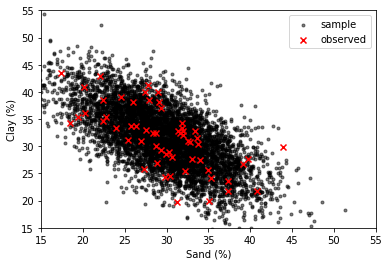

In [11]:
samp = pd.DataFrame(particle_sample, columns=['sandTotal', 'clayTotal', 'siltTotal'])

plt.scatter(samp.sandTotal, samp.clayTotal, marker='.', color='k', alpha=0.5, label='sample');
plt.scatter(df.sandTotal, df.clayTotal, marker='x', color='r', label='observed');
plt.xlabel('Sand (%)');
plt.ylabel('Clay (%)');
plt.xlim(15, 55);
plt.ylim(15, 55);
plt.legend();

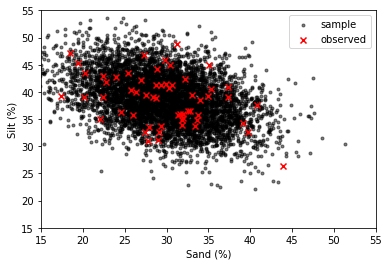

In [12]:
plt.scatter(samp.sandTotal, samp.siltTotal, marker='.', color='k', alpha=0.5, label='sample');
plt.scatter(df.sandTotal, df.siltTotal, marker='x', color='r', label='observed');
plt.xlabel('Sand (%)');
plt.ylabel('Silt (%)');
plt.xlim(15, 55);
plt.ylim(15, 55);
plt.legend();

The joint distribution look quite reasonable, but this is all of the soil particle distribution pooled together.  It might make more sense to break it up by horrizon.  Then we can locate the sensors within the proper horizon and draw from the appropriate distribution. In the plot below it seems the A horizon is sandier than B.  This makes sense as the A horizon is probably more weathered.

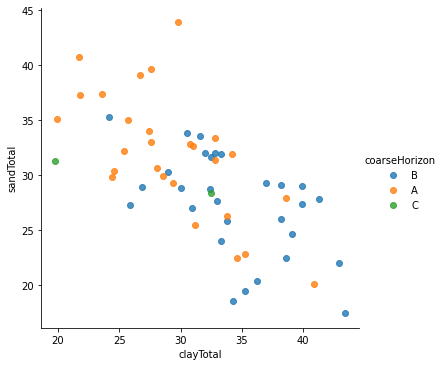

In [13]:
garb = []
for n in df.horizonName:
    if 'A' in n:
        garb.append('A')
    elif 'B' in n:
        garb.append('B')
    else: 
        garb.append('C')
        
df['coarseHorizon'] = garb

sns.lmplot(x='clayTotal', y='sandTotal', data=df, hue='coarseHorizon', fit_reg=False);

Trying to break the horizons up and make different distributions caused marix problems, so I'm putting it on hold for now.  Soem of what I was trying is down in the scrap area. 

pip install vaex

### Matric Potential ###
In the section above we created a joint distribution for clay and sand fractions of the soil. To find a distrbution of matric potential we will draw from that distribution and use the function for matric potential ($\Psi$) that was defined earlier. In the function, $\theta$ is the volumetric soil water content, which is measured by the soil instument arrays. 

Unfortunately some months of data are missing some sensors so we will need to find the sensors common to all of them.

In [20]:
site = 'ABBY'

# glob the files with site data
globstring = os.path.join(data, site + '*.csv')
files = glob(globstring)
files.sort()

for file in files:
    x= len(list(pd.read_csv(file, nrows=1).columns))
    print(f'{file} has {x} columns')
    
# find columns common to all files
cols = set.intersection(*[set(pd.read_csv(f, nrows=1).columns) for f in files])
# remove garbage column
cols = [col for col in list(cols) if 'Unnamed: 0' not in col]
print(f'there are {len(cols)} common to all the files')

/data/ABBY_2018-09.csv has 1116 columns
/data/ABBY_2018-10.csv has 1124 columns
/data/ABBY_2018-11.csv has 1124 columns
/data/ABBY_2018-12.csv has 1116 columns
/data/ABBY_2019-01.csv has 1116 columns
/data/ABBY_2019-02.csv has 1116 columns
/data/ABBY_2019-03.csv has 1084 columns
/data/ABBY_2019-04.csv has 1084 columns
/data/ABBY_2019-05.csv has 1100 columns
/data/ABBY_2019-06.csv has 1100 columns
/data/ABBY_2019-07.csv has 1116 columns
/data/ABBY_2019-08.csv has 1116 columns
/data/ABBY_2019-09.csv has 1004 columns
/data/ABBY_2019-10.csv has 1100 columns
/data/ABBY_2019-11.csv has 1076 columns
/data/ABBY_2019-12.csv has 1092 columns
/data/ABBY_2020-01.csv has 1076 columns
/data/ABBY_2020-02.csv has 1076 columns
/data/ABBY_2020-04.csv has 1052 columns
/data/ABBY_2020-05.csv has 1044 columns
/data/ABBY_2020-06.csv has 1036 columns
there are 912 common to all the files


Now that we have figured out the sensors that are present in each monthly file we can read only those columns into a vaex dataframe.  This is specified by ```kwargs = {'usecols':common}``` which passes the usecols keyword to pandas. 

In [22]:
# Convert each CSV file to HDF5
kwargs = {'usecols':cols}
for file in files:
    df_tmp = vaex.from_csv(file, convert=True, copy_index=False, **kwargs)
    
# Now read the h5s and combine to single h5
SITE = vaex.open(globstring + '.hdf5')
unitary_h5 = os.path.join(data, site + '*.hdf5')
SITE.export(unitary_h5)

type(SITE)

/usr/local/lib/python3.6/dist-packages/astropy/config/configuration.py:581: ConfigurationMissingWarning: Configuration defaults will be used due to PermissionError:13 on None
  warn(ConfigurationMissingWarning(msg))


vaex.dataframe.DataFrameLocal

In [26]:
# make a list of the sensor locations
sensors = []
for col in SITE.columns:
    sens = col.partition('_')[-1].partition('.')[0]
    # only append non-empty strings
    if sens:
        sensors.append(sens)

sensors = list(set(sensors))

# make a nested dict with the data for each sensor, in an uncomputed
# dask dataframe, under the key 'data' in the sub-dict
sensor_data = {}
for sensor in sensors:
    # find the columns retated to the sensor
    cols  = [col
             for col
             in SITE.columns
             if sensor in col
             and 'Minimum' not in col
             and 'Maximum' not in col
             and 'NumPts' not in col]
    
    # make a list of un-needed cols
    #drops = [col for col in cols if 'Minimum' in col or 'Maximum' in col or 'NumPts' in col]
    #cols = [col for col in cols if col not in drops]
    sensor_data[sensor] = {'data' : SITE[cols]}

### Data pre-processing ###
We will need to do something about nans and bad qf flags then turn columns into tensors for use in the model.  __The bad qfs are all messed up at the moment so we will skip that part__

In order to fill missing values for a given sensor we will use values from the other sensors as inputs to a BNN.

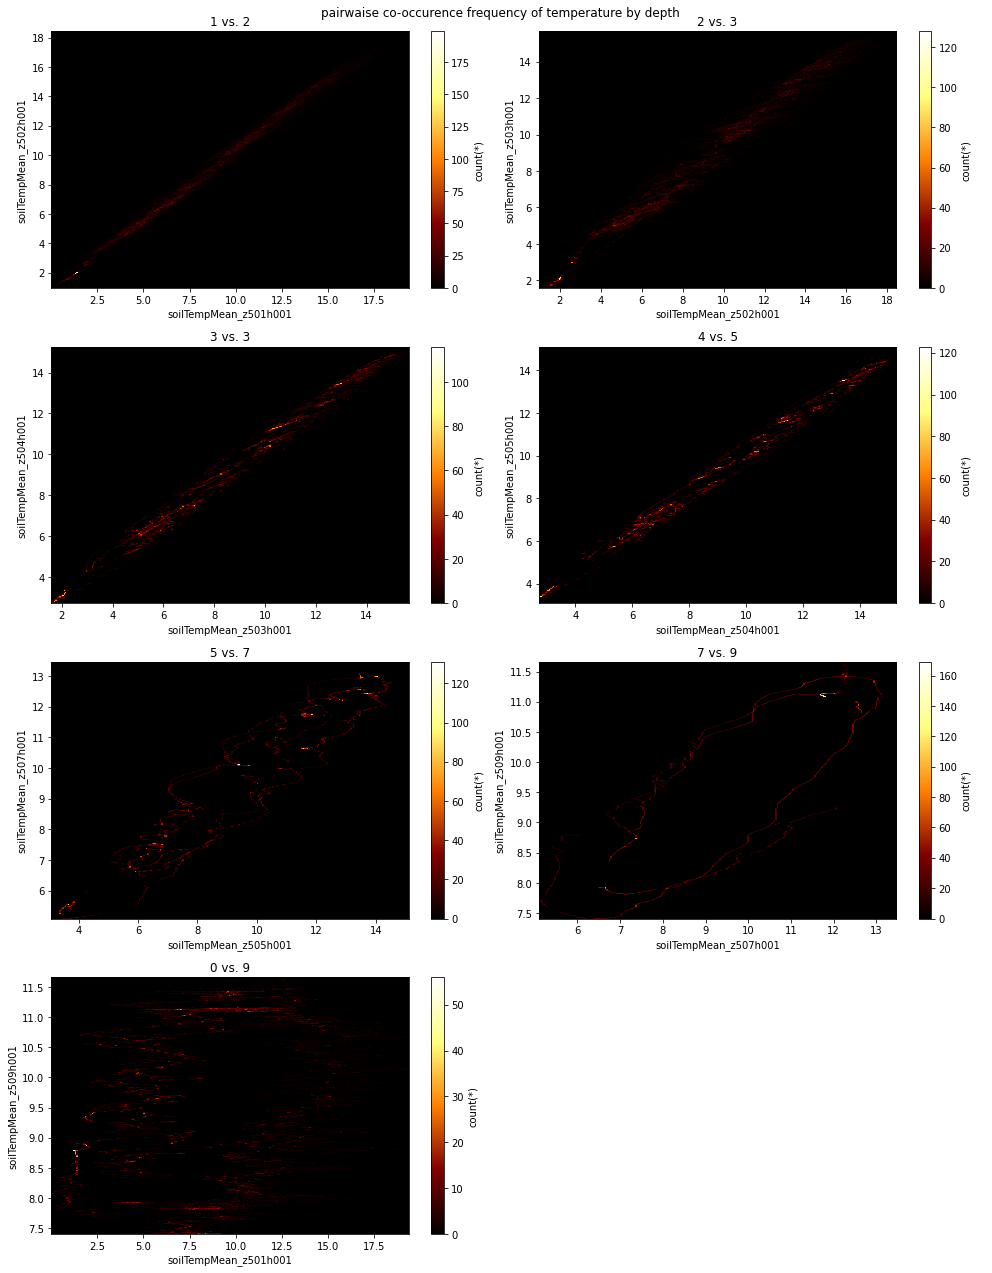

In [28]:
# find soil plots (horizontal locs)
hors = list(set([''.join(s.partition('h')[1:]) for s in sensors]))
hors.sort()

hor = hors[0]

# find the vertical T sensor locations at each plot
vers = [s for s in sensors if hor in s]
vers.sort()

cols = ['soilTempMean_' + ver for ver in vers if 'soilTempMean_' + ver in SITE.columns]

df = SITE[cols]


fig, ax = plt.subplots(4, 2, figsize=(14,18))
fig.suptitle('pairwaise co-occurence frequency of temperature by depth')
plt.sca(ax[0, 0])
df.viz.heatmap(df.soilTempMean_z501h001, df.soilTempMean_z502h001);
ax[0, 0].set_title('1 vs. 2')
plt.sca(ax[0, 1])
df.viz.heatmap(df.soilTempMean_z502h001, df.soilTempMean_z503h001);
ax[0, 1].set_title('2 vs. 3')
plt.sca(ax[1, 0])
df.viz.heatmap(df.soilTempMean_z503h001, df.soilTempMean_z504h001);
ax[1, 0].set_title('3 vs. 3')
plt.sca(ax[1, 1])
df.viz.heatmap(df.soilTempMean_z504h001, df.soilTempMean_z505h001);
ax[1, 1].set_title('4 vs. 5')
plt.sca(ax[2, 0])
df.viz.heatmap(df.soilTempMean_z505h001, df.soilTempMean_z507h001);
ax[2, 0].set_title('5 vs. 7')
plt.sca(ax[2, 1])
df.viz.heatmap(df.soilTempMean_z507h001, df.soilTempMean_z509h001);
ax[2, 1].set_title('7 vs. 9')
plt.sca(ax[3, 0])
df.viz.heatmap(df.soilTempMean_z501h001, df.soilTempMean_z509h001);
ax[3, 0].set_title('0 vs. 9')
ax[3, 1].axis('off');


If we look at the plots above we can see that there is strong correlation between close sensors.  It seems to be a linear correlation near the surface, while deeper there seems to be a bit of historesis.  There is pronounced, albeit noisy, historesis between the top and bottom layer.  It seems likely that a BNN should be able to learn this based on the gradient at any given time.  First we must separate each time series into part with values and parts without. __Nope nope nope! it turns out the sensors in the same plot almost always are nans at the sametime__.  We will have to use sensors from other plots to infer.

When we use the SWC as an input to the model we will add guassian noise to reflect the uncertainty in the data.  Each sensor has an ```ExpUncert``` column which represents the 95\% confidence interval.  We will take the mean of this column (perhaps after dropping values outside of its 0.95 quantile, so that insane outliers do not skew it) as being 2$\sigma$.  We will then use $\sigma$ to paramaterize the guassian noise.  

First lets make a function to create the noise distribution.

In [88]:
def make_swc_noise(ExpUncert):
    '''Takes ExpUncert as dask array, returns tf.random.normal
    paramaterized by pooled mean of standard dev'''

    # trim out extreme values
    low_q  = np.quantile(ExpUncert, 0.025)
    high_q = np.quantile(ExpUncert, 0.975)
    tame = ExpUncert[ExpUncert>low_q]
    tame = tame[tame<high_q]
    stddev = tame.mean() / 2.0
    stddev = dd.compute(stddev)
    
    print(f'stddev is of type {type(stddev)}')
    print(f'shape is of type {type(ExpUncert.shape)}')
    
    # make guassian
    gnoise = tf.random.normal(shape=ExpUncert.shape, mean=0.0, stddev=stddev, dtype=tf.float32)
    
    return(gnoise)

In [89]:
# get the mean of all soilTempExpUncert columns
uncert = [c for c in SITE.columns if 'soilTempExpUncert' in c]
uncert = SITE[uncert].values.astype(np.float32).flatten()
uncert = uncert[np.logical_not(np.isnan(uncert))].mean()
uncert

0.14047544

In [90]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [99]:
doink = {'a':[1, 1, 1, 1, 1, 1, 1, 0],
         'b':[0, 0, 0, 0, 1, 1, 0, 1],
         'c':[1, 1, 1, 0, 0, 1, 1, 1],
         'd':[1, 0, 0, 0, 1, 1, 1, 1],
         'e':[1, 1, 1, 1, 1, 1, 0, 0],
         'f':[0, 0, 0, 0, 0, 1, 1, 1]}

doink = pd.DataFrame(doink)

temp = doink.sum()
min_col = temp[temp==temp.max()].index.values[0]
print(min_col)

temp = doink.groupby(min_col).sum().iloc[1]
temp[temp >= 0.7*temp.max()].index.values


a


array(['c', 'e'], dtype=object)

In [119]:
def data_to_pandas(df, cols):
    '''changes the df from vaex to pandas'''
    # make timeBgn into datetime
    df['timeBgn'] = df.timeBgn.astype('datetime64')
    # create dask array of values from the df
    da = df[cols].to_dask_array()
    idx = df['timeBgn'].to_dask_array()
    # make a dask df
    ddf = dd.from_array(da, columns=cols)
    idx  = dd.from_array(idx)
    ddf = ddf.merge(idx.to_frame(name='timeBgn'))
        
    # convert to pandas df
    data = ddf.compute() 
    data.index = pd.to_datetime(data.timeBgn)
    data = data.asfreq('0.5H')
    #data['timeBgn'] = data.index
    
    return(data)


def split_df_n2_good_and_bad_cols(data):
    '''splits the df by column based on compatibility with best column'''
    # find locations of non-NaNs
    good_value_df = pd.DataFrame()
    for c in data.columns:
        good_value_df[c] = ~data[c].isna()
    
    good_value_df.set_index('timeBgn')
    date_time = data.pop('timeBgn')
    
    # convert from bool to int
    for c in data.columns:
        good_value_df[c] = good_value_df[c].astype(int) 
    
    # find the column with the fewest NanS
    temp = good_value_df.sum()
    max_col = temp[temp==temp.max()].index.values[0]
    
    # find cols whith enough in common with max_col
    temp = good_value_df.groupby(max_col).sum().iloc[1]
    good_cols = temp[temp >= 0.7*temp.max()].index.values
    bad_cols = [c for c in data.columns if c not in good_cols]
    good_cols = [c for c in good_cols if 'timeBgn' not in c]

    # make dict with indices of non-NAN entires
    vals = [np.where(good_value_df[c].values > 0)[0] for c in good_value_df.columns]
    good_indices_dict = dict(zip(list(good_df.columns), vals))
    
    
    
    return(good_df, bad_df)
    
    
    
    
cols = [c for c in  SITE.columns if ('timeBgn' not in c) and (('Mean' in c) or ('ExpUncert' in c))]
cols = [c for c in cols if 'VSIC' not in c]

good_df, bad_df = split_df_n2_good_and_bad_cols(data_to_pandas(SITE, cols))

bad_df.index

DatetimeIndex(['2018-09-01 00:00:00', '2018-09-01 00:30:00',
               '2018-09-01 01:00:00', '2018-09-01 01:30:00',
               '2018-09-01 02:00:00', '2018-09-01 02:30:00',
               '2018-09-01 03:00:00', '2018-09-01 03:30:00',
               '2018-09-01 04:00:00', '2018-09-01 04:30:00',
               ...
               '2020-06-30 19:00:00', '2020-06-30 19:30:00',
               '2020-06-30 20:00:00', '2020-06-30 20:30:00',
               '2020-06-30 21:00:00', '2020-06-30 21:30:00',
               '2020-06-30 22:00:00', '2020-06-30 22:30:00',
               '2020-06-30 23:00:00', '2020-06-30 23:30:00'],
              dtype='datetime64[ns]', name='timeBgn', length=32112, freq='30T')

In [ ]:


def data_prep(data)
    # find locations of non-NaNs
    good_value_df = pd.DataFrame()
    for c in data.columns:
        good_value_df[c] = ~data[c].isna()
    
    good_value_df.set_index('timeBgn')
    date_time = data.pop('timeBgn')
    
    # convert from bool to int
    for c in data.columns:
        good_value_df[c] = bad_value_df[c].astype(int) 
    
    # find the column with the fewest NanS
    temp = good_value_df.sum()
    max_col = temp[temp==temp.max()].index.values[0]
    
    # find cols whith enough in common with max_col
    temp = good_value_df.groupby(max_col).sum().iloc[1]
    good_cols = temp[temp >= 0.7*temp.max()].index.values
    
    # using only good_cols make dict with indices of bad values
    cols = [c for c in bad_value_df.columns if 'timeBgn' not in c]
    vals = [np.where(bad_value_df[c].values > 0)[0] for c in cols]
    bad_indices_dict = dict(zip(cols, vals))
    
    
    
    #  and also an array with union of  bad rows
    u = list(set.union(*map(set,vals)))
    u.sort()
    
    ######
    _ = [len(v) for v in vals]
    q = np.quantile(_, 0.9)
    _ = [v for v in _ if v < 0.5 * len(data)]
    _ = plt.hist(_)
    plt.show()
    #####
    
    u = np.array(u)
    
   
    
    # find lengths of bad chuncks, sourt of (hence inv)
    inv_bad_chunk_len = (u - np.roll(u, 1))[1:]
    print('inv1', inv_bad_chunk_len.max())
    
    # find nans that occur as singles, and their indices
    single_nans = np.array(list(inv_bad_chunk_len > 1) + [0])
    single_nan_ndcs =  u[single_nans > 0]

    # replace single NaNs with the mean of their nearest temporal neighbours
    for k, v in bad_indices_dict.items():
        local_singles = set.intersection(set(single_nan_ndcs), set(v))
        for single in local_singles:
            data[k].iloc[single] = (data[k].iloc[single+1] + data[k].iloc[single-1]) / 2
    
    # re-make dict with indices of bad values and also an array with union of  bad rows
    cols = [c for c in bad_value_df.columns if 'timeBgn' not in c]
    vals = [np.where(bad_value_df[c].values > 0)[0] for c in cols]
    bad_indices_dict = dict(zip(cols, vals))
    u = list(set.union(*map(set,vals)))
    u.sort()
    u = np.array(u)
    
    # find lengths of bad chuncks again, sourt of (hence inv)
    inv_bad_chunk_len = (u - np.roll(u, 1))[1:]
    print('inv2', inv_bad_chunk_len.max())
    
    # get the start and stop  indices of the 2 longest contiguos good data chunks
    two_chains = np.argsort(-inv_bad_chunk_len)[:2]
    # prepare them to be slice indices for train and val sets
    ts, te = u[two_chains[0]] + 1, u[two_chains[0]+1]
    vs, ve = u[two_chains[1]] + 1, u[two_chains[1]+1]
    
    print('2chainz:', np.argsort(-inv_bad_chunk_len)[:10])

    
    
    # make a datetime series and a timestamp (in seconds) series
    
    timestamp_s = date_time.map(pd.Timestamp.timestamp)
    date_time = pd.to_datetime(date_time)
    
    # make 'time of day' and 'time of year' input signals
    day = 24*60*60
    year = (365.2425)*day

    data['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    data['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    data['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    data['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    
    return(data, bad_indices_dict, ts, te, vs, ve)

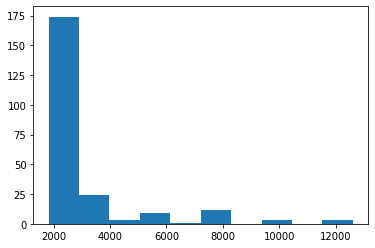

inv1 1
inv2 1
2chainz: [    0 21415 21414 21413 21412 21411 21410 21409 21408 21407]


(21416, 21416)

In [75]:
cols = [c for c in  SITE.columns if ('timeBgn' not in c) and (('Mean' in c) or ('ExpUncert' in c))]
cols = [c for c in cols if 'VSIC' not in c]

batch_size = 32
past_window_size = 100
fut_window_size  = 100
val_window_size  = 100

d, bad_indices_dict, ts, te, vs, ve = data_prep1(SITE, cols)

# extract the contigous portions for training
train  = d.values
tr_idx = d.index.values[ts:te]

val = d.values[vs:ve]
val_idx = d.index.values[vs:ve]


vs, ve

#dataset = tf.data.Dataset.from_tensor_slices(d)
#dataset = dataset.batch(batch_size)



# make dataset
#dataset = tf.data.Dataset.from_tensor_slices(data_arrays)

# divide into training and validation windows


In [26]:
train.shape

(32112, 251)

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
          self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])


# add function to cretae window to create two windows
# - an input window, and output window -from a list of conecutive inputs
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window


# Add a function to create datset
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset


# add a plotting function
def plot(self, model=None, plot_col=None, max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                marker='X', edgecolors='k', label='Predictions',
                c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

# add properties for accessing dtaset
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example




MAX_EPOCHS = 2

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

        

2245 2244
<BatchDataset shapes: (None, None, 8), types: tf.float32>
Epoch 1/2
218/218 [==============================] - 8s 27ms/step - loss: 0.1631 - mean_absolute_error: 0.2461 - val_loss: 0.4557 - val_mean_absolute_error: 0.4019
Epoch 2/2
74/74 [==============================] - 1s 12ms/step - loss: 0.2741 - mean_absolute_error: 0.3142
data shape (32112, 8)

pre shape: (64, 100, 8)


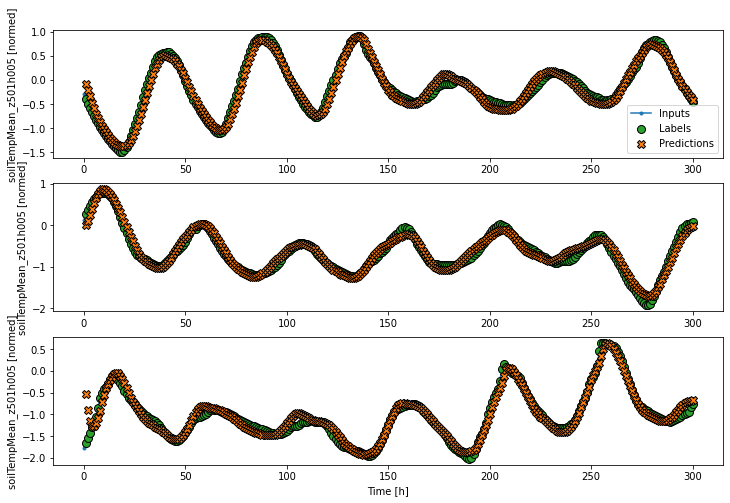

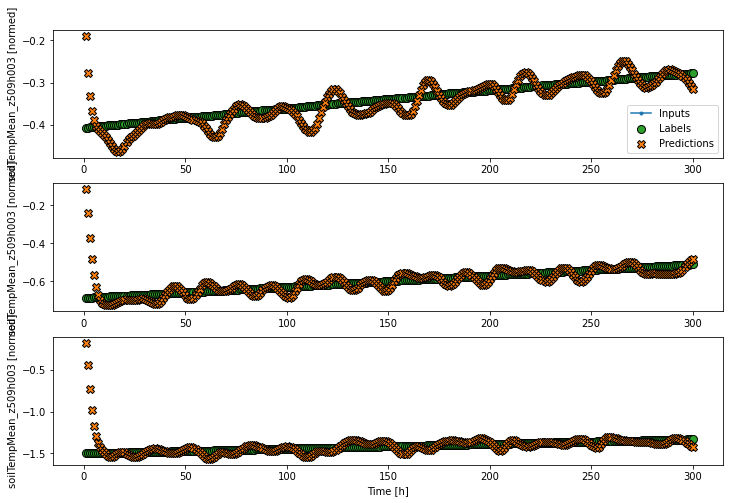

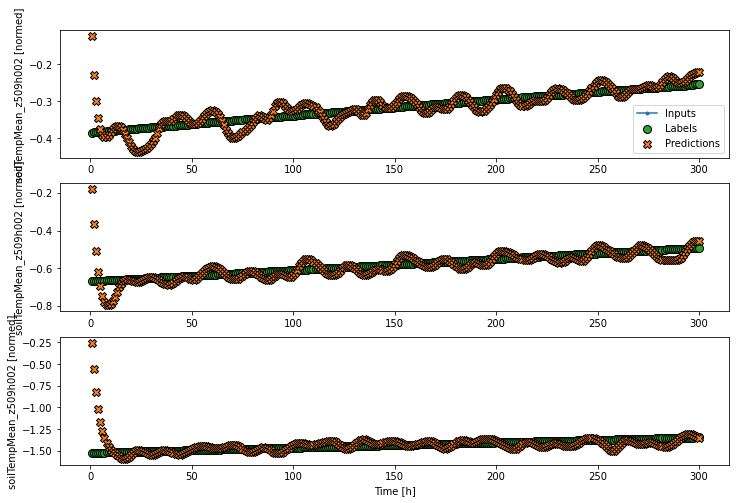

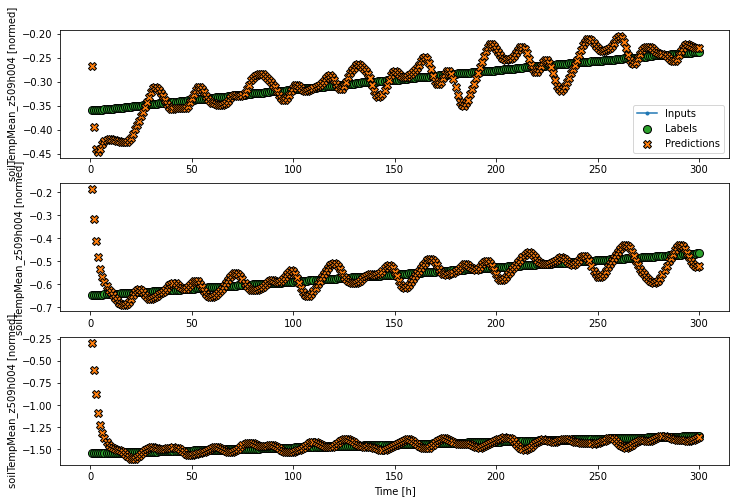

In [174]:
def bnn_impute(df, col, verbose=1):
    tf.keras.backend.clear_session()
    # seperate the name of value of interest from the sensor name
    val = col.split('_')[0]
    expun = val + 'ExpUncert'
    uncert = [c for c in SITE.columns if 'soilTempExpUncert' in c]
    uncert = df[uncert].values.astype(np.float32).flatten()
    noise_std = np.float32(uncert[np.logical_not(np.isnan(uncert))].mean() / 2)
    
    # find all of the colums corresponding to the value of interest at other sensors
    feature_names = [c for c in df.columns if col not in c and val in c]
    feature_names.sort()
    cols = [col] + feature_names
    
    # make timeBgn into datetime
    df['timeBgn'] = df.timeBgn.astype('datetime64')
    # create dask array of values from the df
    da = df[cols].to_dask_array()
    idx = df['timeBgn'].to_dask_array()
    # make a dask df
    ddf = dd.from_array(da, columns=cols)
    idx  = dd.from_array(idx)
    ddf = ddf.merge(idx.to_frame(name='timeBgn'))
    # get the 20 feature columns with the fewest NaNs
    best_cols = list(ddf[feature_names].isnull().sum().nsmallest(21).index)
    # now reduce that to the three  (of the 20) wich correlate most with col
    cor = ddf[[col] + best_cols].corr().compute()
    best_cols = list(cor[col].sort_values().head(3).index)
    
    # make a df of just the best_cols and convert to pandas df
    data = ddf[['timeBgn', col] + best_cols]
    data = data.compute() 
    data.index = pd.to_datetime(data.timeBgn)
    data = data.asfreq('0.5H')
    data['timeBgn'] = data.index
    
    # find locations of NaNs
    bad_value_df = pd.DataFrame()
    for c in data.columns:
        bad_value_df[c] = data[c].isna()
    bad_value_df.set_index('timeBgn')
    
    for c in [col] + best_cols:
        bad_value_df[c] = bad_value_df[c].astype(int) 
        
    # make dict with indices of bad values and also an array with union of  bad rows
    cols = [c for c in bad_value_df.columns if 'timeBgn' not in c]
    vals = [np.where(bad_value_df[c].values > 0)[0] for c in cols]
    bad_indices_dict = dict(zip(cols, vals))
    u = list(set.union(*map(set,vals)))
    u.sort()
    u = np.array(u)
    
    # find lengths of bad chuncks, sourt of (hence inv)
    inv_bad_chunk_len = (u - np.roll(u, 1))[1:]
    
    # find nans that occur as singles, and their indices
    single_nans = np.array(list(inv_bad_chunk_len > 1) + [0])
    single_nan_ndcs =  u[single_nans > 0]

    # replace single NaNs with the mean of their nearest temporal neighbours
    for k, v in bad_indices_dict.items():
        local_singles = set.intersection(set(single_nan_ndcs), set(v))
        for single in local_singles:
            data[k].iloc[single] = (data[k].iloc[single+1] + data[k].iloc[single-1]) / 2
    
    # re-make dict with indices of bad values and also an array with union of  bad rows
    cols = [c for c in bad_value_df.columns if 'timeBgn' not in c]
    vals = [np.where(bad_value_df[c].values > 0)[0] for c in cols]
    bad_indices_dict = dict(zip(cols, vals))
    u = list(set.union(*map(set,vals)))
    u.sort()
    u = np.array(u)
    
    # find lengths of bad chuncks again, sourt of (hence inv)
    inv_bad_chunk_len = (u - np.roll(u, 1))[1:]
    
    print(len(u), len(inv_bad_chunk_len))
    
    # get the start and stop  indices of the longest contiguos good data chunk
    two_chains = np.argsort(-inv_bad_chunk_len)[:2]
    # prepare them to be slice indices for train and val sets
    ts, te = u[two_chains[0]] + 1, u[two_chains[0]+1]
    vs, ve = u[two_chains[1]] + 1, u[two_chains[1]+1]



   



    #bad_value_df[[col] + best_cols].plot(subplots=True, figsize=(12, 12))
    
    '''
    # plot
    data[[col] + best_cols].plot(subplots=True, figsize=(12, 12))
    data[[col] + best_cols][:480].plot(subplots=True, figsize=(12, 12))
    '''
    # make a datetime series and a timestamp (in seconds) series
    date_time = data.pop('timeBgn')
    timestamp_s = date_time.map(pd.Timestamp.timestamp)
    date_time = pd.to_datetime(date_time)
    
    # make 'time of day' and 'time of year' input signals
    day = 24*60*60
    year = (365.2425)*day

    data['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    data['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    data['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    data['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    
    # keep track of column indices
    column_indices = {name : i for i , name in enumerate(data.columns)}
         
    # train test val split, using slice indices of contigous chunks
    n = len(data)
    num_features = data.shape[1]
    
    train_df = data[ts:te]
    val_df = data[vs:ve]
    test_df = data[int(n*0.9):]

    # normalize (scale and center)
    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    # should I be using the full dset mean and std?
    data = (data -train_mean) / train_std
    data_ = np.array(data, dtype=np.float32) 
    '''
    # look at distributions
    df_std = (data - train_mean) / train_std
    df_std = df_std.melt(var_name='Column', value_name='Normalized')
    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
    _ = ax.set_xticklabels(data.keys(), rotation=90)
    plt.title('Distirbution of data by column')
    '''
    # make window
    window_size = 300
    w = WindowGenerator(train_df=train_df,
                        val_df=val_df,
                        test_df=test_df,
                        input_width=window_size,
                        label_width=window_size,
                        shift=1)
    # make full dataset as tensor for predictions
    full = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data_,
        targets=None,
        sequence_length=len(data),
        sequence_stride=1,
        shuffle=False,
        batch_size=32)
    
    # create an RNN model
    lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.Dense(units=num_features)
    ])

   
    print(full)
     
    # fit model
    history = compile_and_fit(lstm_model, w)

    
    val_performance = lstm_model.evaluate(w.val)
    performance = lstm_model.evaluate(w.test, verbose=0)

    for c in [col] + best_cols:
        w.plot(lstm_model, plot_col=c)
    
    predictions = []
    
    input_data = data_[:-100]
    targets = data_[100:]
    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    input_data, targets, sequence_length=100, batch_size=64)

    for element in dataset:
        predictions.append(lstm_model.predict(element[0]))
 
    print('data shape', data_.shape)
    print()
    print('pre shape:', predictions[0].shape)
    
    
    
    
    
    return(lstm_model, predictions, data, [col]+best_cols, column_indices)
    #eturn(model)
    
    



col = 'soilTempMean_z501h005'


mod, pred, d, ccc, cidx = bnn_impute(SITE, col)

#bvdf = bnn_impute(SITE, col)




<AxesSubplot:>

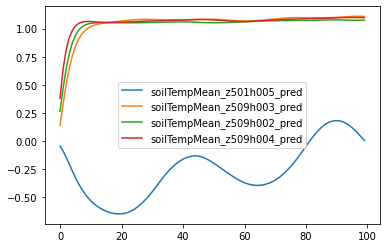

In [191]:
foam = d[ccc]
new_cols = [k + '_pred' for k in list(cidx.keys())[:4]]

p = pred[0]
mu = np.mean(p, axis=0)[:,:4]
sd = np.std(p, axis=0)[:,:4]
pred_df = pd.DataFrame(mu, columns=new_cols)
pred_df = pred_df.merge(foam, left_index=True, right_index=True)
pred_df.plot()

In [ ]:
'''
pred_df = pd.DataFrame(pred[0].squeeze()[:,:4], columns=new_cols)
pred_df.index = foam.index
pred_df = pred_df.merge(foam, left_index=True, right_index=True)
pred_df[['soilTempMean_z509h003', 'soilTempMean_z509h003_pred']]['2018-09-12' : '2018-09-15'].plot();
'''

In [153]:
pred_df.head(580)

,soilTempMean_z501h005_pred,soilTempMean_z509h003_pred,soilTempMean_z509h002_pred,soilTempMean_z509h004_pred,soilTempMean_z501h005,soilTempMean_z509h003,soilTempMean_z509h002,soilTempMean_z509h004
timeBgn,,,,,,,,
2018-09-01 00:00:00,0.471030,0.443075,0.452597,0.423600,1.186304,1.066757,1.054268,1.207702
2018-09-01 00:30:00,0.817748,0.741720,0.730816,0.732241,1.112430,1.067587,1.054268,1.208551
2018-09-01 01:00:00,1.016720,0.934599,0.900902,0.940870,1.066259,1.067587,1.054983,1.208551
2018-09-01 01:30:00,1.082736,1.048035,1.011031,1.074315,1.003226,1.068416,1.054983,1.208551
2018-09-01 02:00:00,1.046639,1.109463,1.084849,1.151083,0.910884,1.068416,1.055699,1.208551
...,...,...,...,...,...,...,...,...
2018-09-12 23:30:00,0.006518,1.282092,1.238737,1.242761,-0.055493,1.232610,1.202342,1.314672
2018-09-13 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-13 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [207]:
def ts_data_generator(data, window_size, batch_size, shuffle_buffer):
    '''
    Utility function for time series data generation in batches
    '''
    ts_data = tf.data.Dataset.from_tensor_slices(data)
    ts_data = ts_data.window(window_size + 1, shift=1, drop_remainder=True)
    ts_data = ts_data.flat_map(lambda window: window.batch(window_size + 1))
    ts_data = ts_data.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    ts_data = ts_data.batch(batch_size).prefetch(1)
    return ts_data

def bnn_impute(df, col, verbose=1):
    # seperate the name of value of interest from the sensor name
    val = col.split('_')[0]
    expun = val + 'ExpUncert'
    uncert = [c for c in SITE.columns if 'soilTempExpUncert' in c]
    uncert = df[uncert].values.astype(np.float32).flatten()
    noise_std = np.float32(uncert[np.logical_not(np.isnan(uncert))].mean() / 2)
    
    # find all of the colums corresponding to the value of interest at other sensors
    feature_names = [c for c in df.columns if col not in c and val in c]
    feature_names.sort()
    cols = [col] + feature_names
    
    # make timeBgn into datetime
    df['timeBgn'] = df.timeBgn.astype('datetime64')
    # create dask array of values from the df
    da = df[cols].to_dask_array()
    idx = df['timeBgn'].to_dask_array()
    # make a dask df
    ddf = dd.from_array(da, columns=cols)
    idx  = dd.from_array(idx)
    ddf = ddf.merge(idx.to_frame(name='timeBgn'))
    # get the 20 feature columns with the fewest NaNs
    best_cols = list(ddf[feature_names].isnull().sum().nsmallest(21).index)
    # now reduce that to the three  (of the 20) wich correlate most with col
    cor = ddf[[col] + best_cols].corr().compute()
    best_cols = list(cor[col].sort_values().head(3).index)
    
    # make a df of just the best_cols and convert to pandas df
    data = ddf[['timeBgn', col] + best_cols]
    data = data.compute() 
    data.index = pd.to_datetime(data.timeBgn)
    data = data.asfreq('0.5H')
    data['timeBgn'] = data.index
    
    # backfill NaNs, but keep track of where tehy were
    bad_value_df = pd.DataFrame()
    for c in data.columns:
        bad_value_df[c] = data[c].isna()
    bad_value_df.set_index('timeBgn')
    
    for c in [col] + best_cols:
        bad_value_df[c] = bad_value_df[c].astype(int) 
        
    data = data.fillna(method='bfill')
    
    
    #bad_value_df[[col] + best_cols].plot(subplots=True, figsize=(12, 12))
    
    #return(bad_value_df, [col] + best_cols)
    
    # plot
    data[[col] + best_cols].plot(subplots=True, figsize=(12, 12))
    data[[col] + best_cols][:480].plot(subplots=True, figsize=(12, 12))
    
    # make a datetime series and a timestamp (in seconds) series
    date_time = data.pop('timeBgn')
    timestamp_s = date_time.map(pd.Timestamp.timestamp)
    date_time = pd.to_datetime(date_time)
    
    # make 'time of day' and 'time of year' input signals
    day = 24*60*60
    year = (365.2425)*day

    data['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    data['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    data['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    data['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    
    # keep track of column indices
    column_indices = {name : i for i , name in enumerate(data.columns)}
         
    # train test val split
    n = len(data)
    num_features = data.shape[1]
    
    train_df = data[0:int(n*0.7)]
    val_df = data[int(n*0.7):int(n*0.9)]
    test_df = data[int(n*0.9):]

    # normalize (scale and center)
    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    # should I be using the full dset mean and std?
    data = (data -train_mean) / train_std
    
    # look at distributions
    df_std = (data - train_mean) / train_std
    df_std = df_std.melt(var_name='Column', value_name='Normalized')
    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
    _ = ax.set_xticklabels(data.keys(), rotation=90)
    plt.title('Distirbution of data by column')

    # make window
    window_size = 50
    batch_size = 32
    shuff_buf = 1000
    
    
    
    
    # create an RNN model
    lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(batch_size, return_sequences=True),
        tf.keras.layers.Dense(units=num_features)
    ])

    print('Input shape:', w.example[0].shape)
    print('Output shape:', lstm_model(w.example[0]).shape)
    
    # fit model
    history = compile_and_fit(lstm_model, w)

    
    val_performance = lstm_model.evaluate(w.val)
    performance = lstm_model.evaluate(w.test, verbose=0)

    for c in [col] + best_cols:
        w.plot(lstm_model, plot_col=c)
    
    
    predictions = []
    for t in range(len(data) - window_size):
        predictions.append(model.predict(data[t:t + window_size][np.newaxis]))
        
    
    
    
    
    
    
    return(model, predictions, w.test)
    #eturn(model)
    
    



col = 'soilTempMean_z501h005'


mod, pred, test_df = bnn_impute(SITE, col)

# inspect




TypeError: mean() missing 1 required positional argument: 'expression'

When we use the SWC as an input to the model we will add guassian noise to reflect the uncertainty in the data.  Each sensor has an ```ExpUncert``` column which represents the 95\% confidence interval.  We will take the mean of this column (perhaps after dropping values outside of its 0.95 quantile, so that insane outliers do not skew it) as being 2$\sigma$.  We will then use $\sigma$ to paramaterize the guassian noise.  

First lets make a function to create the noise distribution.

In [172]:
start = 0
contig=10
bddf.soilTempMean_z501h005.values[start:start + contig]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Test below, looks fine.

In [209]:
l = [1.0, 1.0, 1.0, 1.0, 12.0, 0.001, 1, 1.0, 1.0, 0.5, 0.3, 0.4, 0.7, 0.2, 1.0, 1.0] *10
test = np.array(l)

g = make_swc_noise(test)

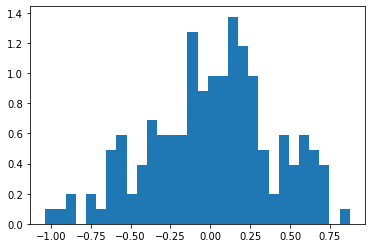

In [210]:
plt.hist(g.numpy(), density=True, bins=30);

In [ ]:
# ----------------------functions from the paper------------------------------
# Saxton, K.E., Rawls, W., Romberger, J.S. and Papendick, R.I., 1986. 
# Estimating generalized soil-water characteristics from texture.


@tf.function  # tf has no native log10
def log10(x):
    numerator = tf.log(x)
    denominator = tf.log(tf.constant(10, dtype=numerator.dtype))
    return(numerator / denominator)


@tf.function
def A(clay, sand):
    '''Saxton et al.'s coeficient A (eq 5) for Rawl's eq'''
    return(100.0 * tf.math.exp(-4.396 - 0.0715 * clay 
           - 4.880e-4 * sand**2 - 4.285e-5 *sand**2 * clay))

@tf.function
def B(clay, sand): 
    '''Saxton et al.'s coeficient B (eq 6) for Rawl's eq'''
    return(-3.140 - 0.00222 * clay**2 - 3.484e-5 * sand**2 * clay)

@tf.function
def Ψ0(Θ, clay, sand):
    '''calculates matric potential above 10kPa
    using Rawl's eq (eq2 in saxton)'''
    return(A(clay, sand) * Θ**B(clay, sand))

@tf.function
def Θs(clay, sand):
    '''calculates moisture content at saturation (saxton eq 7)'''
    return(0.332 - 7.251e-4 * sand + 0.1276 * log10(clay))

@tf.function
def Ψe(clay, sand):
    '''calculates air entry potential (saxton eq 8)'''
    return(100.0 * (-0.108 + 0.341 * Θs(clay, sand)))

@tf.function
def theta10kPa(clay, sand):
    '''inverse of Ψ0 (eq2)'''
    return((10 / A(clay, sand))**(1/B(clay, sand)))

@tf.function
def theta_e(clay, sand):
    '''finds theta at air entry potential'''
    A_ = lambda clay, sand : Ψe(clay, sand) / Θs(clay, sand)**B(clay, sand)
    return((Ψe(clay, sand) / A_(clay, sand))**(1/B(clay, sand)))

@tf.function
def Ψ1(Θ, clay, sand):
    '''calculates matric potential as linear function between
    10kPa and air entry'''
    Θ_10KpA = theta10kPa(clay, sand)
    Θ_Ψe    = theta_e(clay, sand)
    slope = (10 - Ψe(clay, sand)) / (Θ_10KpA - Θ_Ψe)
    intercept =   -slope * Θ_10KpA + 10
    return(slope * Θ + intercept)

@tf.function
def Ψ(Θ, clay, sand):
    '''calculates matric potential across full range'''
    Θ_10KpA = theta10kPa(clay, sand)
    Θ_Ψe    = theta_e(clay, sand)
    if Θ < Θ_10KpA:
        return(Ψ0(Θ, clay, sand))
    elif Θ_10KpA < Θ < Θ_Ψe :
        return(Ψ1(Θ, clay, sand))
    else:
        return(0)



In [224]:
key = 'z501h001'
data = sensor_data[key]['data'][['soilCO2concentrationMean_z501h001', 'soilCO2concentrationExpUncert_z501h001']]
g = make_swc_noise(data.soilCO2concentrationExpUncert_z501h001)

stddev is of type <class 'tuple'>
shape is of type <class 'tuple'>


ValueError: Attempt to convert a value (dd.Scalar<size-ag..., dtype=int64>) with an unsupported type (<class 'dask.dataframe.core.Scalar'>) to a Tensor.

In [566]:
key = 'z501h001'
data = sensor_data[key]['data']
Θ = tf.constant

clay, sand

Ψ(Θ, clay, sand)

NameError: name 'Θ' is not defined

In [169]:
ABBY.columns

Index(['Unnamed: 0', 'timeBgn', 'data.fluxCo2.nsae.flux',
       'qfqm.fluxCo2.nsae.qfFinl', 'data.fluxTemp.nsae.flux',
       'qfqm.fluxTemp.nsae.qfFinl', 'data.fluxH2o.nsae.flux',
       'qfqm.fluxH2o.nsae.qfFinl', 'soilCO2concentrationMean_z501h001',
       'soilCO2concentrationMinimum_z501h001',
       ...
       'soilTempMaximum_z508h005', 'soilTempVariance_z508h005',
       'soilTempNumPts_z508h005', 'soilTempExpUncert_z508h005',
       'soilTempStdErMean_z508h005', 'finalQF_z508h005', 'secPrecipBulk',
       'secPrecipExpUncert', 'secPrecipRangeQF', 'secPrecipSciRvwQF'],
      dtype='object', length=1116)

In [92]:
sens = 'z501h001'
swc_mean = 'VSWCMean_' + sens
swc_uncert = 'VSWCExpUncert_' + sens
swc = sensor_data[sens]['data'][swc_mean]
swc95 = sensor_data[sens]['data'][swc_uncert]

In [87]:
sensor_data[sens]['data'].columns

Index(['soilCO2concentrationMean_z501h001',
       'soilCO2concentrationVariance_z501h001',
       'soilCO2concentrationExpUncert_z501h001',
       'soilCO2concentrationStdErMean_z501h001', 'finalQF_z501h001.x',
       'VSWCMean_z501h001', 'VSWCVariance_z501h001', 'VSWCExpUncert_z501h001',
       'VSWCStdErMean_z501h001', 'VSWCFinalQF_z501h001', 'VSICMean_z501h001',
       'VSICVariance_z501h001', 'VSICExpUncert_z501h001',
       'VSICStdErMean_z501h001', 'VSICFinalQF_z501h001',
       'soilTempMean_z501h001', 'soilTempVariance_z501h001',
       'soilTempExpUncert_z501h001', 'soilTempStdErMean_z501h001',
       'finalQF_z501h001.y'],
      dtype='object')

# scrap

In [ ]:
# This was an effort to use a BNN to fill missing sensor values based
# on co-located sensors, but it turns out they tend to go out in clusters

def make_fill_model(df, col, features):
    cols = [col] + features
    
    # scale features to zero mean and unit variance
    scaler = vxml.StandardScaler(features=features, prefix='scaled_')
    scaler.fit(df)
    df_trans = scaler.transform(df)
    
    # seperate nans from data
    df.select(df[col].isnan())
    predict_dict = {c : df.evaluate(df[c], selection=True) for c in features}
    
    
    
    # split not nans into train, test
    #train_data, test_data = data.ml.train_test_split(test_size=0.2, verbose=False)
    
    #detector = IsolationForest(n_estimators=1000, behaviour="deprecated", contamination="auto", random_state=0)

    return(predict_dict)

col = 'soilTempMean_z509h001'
features = [c for c in df.columns if col not in c]

df_trans = make_fill_model(df, col, features)

# save the pipeline to apply to predictions
#state = df_trans.state_get()

df_trans

In [522]:
# this was in an effort to make a soil particle distribution for each horizon,
# but it proved tricky, and might not be woth the effort

def make_soil_dist(horizon_df):
    '''makes a multivariate distribution of soil particle size based on df'''
    
    # get params for prior joint distribution
    sand_mean = horizon_df.sandTotal.values.astype(np.float32).mean()
    clay_mean = horizon_df.clayTotal.values.astype(np.float32).mean()
    silt_mean = horizon_df.siltTotal.values.astype(np.float32).mean()

    cov = horizon_df[['sandTotal', 'clayTotal', 'siltTotal']].cov().values.astype(float)
    cov = cov.tolist()
    
    # cholesky the cov!
    try:    # ____just cholesky it
        scale_tril = tf.linalg.cholesky(cov)
    except: # ____add jitter to avoid degenerate eignevalues
        # make a symmetric (real + symmetric --> self-adjoint) version 
        cov_ = (cov + tf.transpose(cov))/2
        # get eigenvalues and eigenvectors
        e,v = tf.linalg.eigh(cov_)
        # make sure values are positive
        e = tf.where(e > 0, e, tf.zeros_like(e))
        # make new matrix
        cov_ = tf.matmul(tf.matmul(v,tf.linalg.diag(e),transpose_a=True),v)
        scale_tril = tf.linalg.cholesky(cov_)
    
    # make a multivariate normal
    particle_dist = tfd.MultivariateNormalTriL(
        loc = [sand_mean, clay_mean, silt_mean],
        scale_tril=scale_tril)
    
    return(particle_dist)



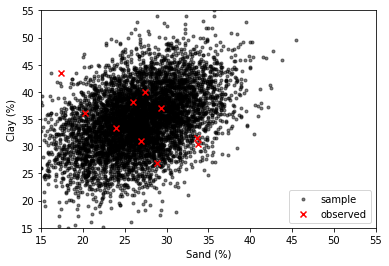

In [545]:
horizon_df = horizon_df_dict['Bw1']
# get params for prior joint distribution
sand_mean = horizon_df.sandTotal.values.astype(np.float32).mean()
clay_mean = horizon_df.clayTotal.values.astype(np.float32).mean()
silt_mean = horizon_df.siltTotal.values.astype(np.float32).mean()

cov = horizon_df[['sandTotal', 'clayTotal', 'siltTotal']].cov().values.astype(float)
cov = cov.tolist()

# cholesky the cov!
try:    # ____just cholesky it
    scale_tril = tf.linalg.cholesky(cov)
except: # ____add jitter to avoid degenerate eignevalues
    # make a symmetric (real + symmetric --> self-adjoint) version 
    cov_ = (cov + tf.transpose(cov))/2
    # get eigenvalues and eigenvectors
    e,v = tf.linalg.eigh(cov_)
    # make sure values are positive
    e = tf.where(e > 0, e, tf.zeros_like(e))
    # make new matrix
    cov_ = tf.matmul(tf.matmul(v,tf.linalg.diag(e),transpose_a=True),v)
    scale_tril = tf.linalg.cholesky(cov_)

aa = tfd.MultivariateNormalTriL(loc = [sand_mean, clay_mean, silt_mean], scale_tril=scale_tril)

aa_sample = aa.sample(6000).numpy()


samp = pd.DataFrame(aa_sample, columns=['sandTotal', 'clayTotal', 'siltTotal'])

plt.scatter(samp.sandTotal, samp.clayTotal, marker='.', color='k', alpha=0.5, label='sample');
plt.scatter(horizon_df.sandTotal, horizon_df.clayTotal, marker='x', color='r', label='observed');
plt.xlabel('Sand (%)');
plt.ylabel('Clay (%)');
plt.xlim(15, 55);
plt.ylim(15, 55);
plt.legend();

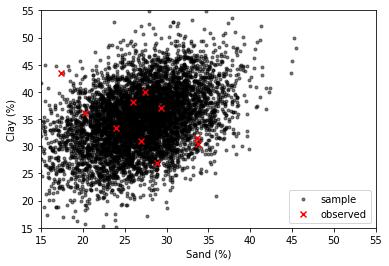

In [530]:
horizon_df = horizon_df_dict['Bw1']
dd = make_soil_dist(horizon_df)

aa_sample = dd.sample(6000).numpy()


samp = pd.DataFrame(aa_sample, columns=['sandTotal', 'clayTotal', 'siltTotal'])

plt.scatter(samp.sandTotal, samp.clayTotal, marker='.', color='k', alpha=0.5, label='sample');
plt.scatter(horizon_df.sandTotal, horizon_df.clayTotal, marker='x', color='r', label='observed');
plt.xlabel('Sand (%)');
plt.ylabel('Clay (%)');
plt.xlim(15, 55);
plt.ylim(15, 55);
plt.legend();

In [542]:
print('aa mean')
print(aa.mean())
print()
print('dd mean')
print(dd.mean())
print()
print('aa covariance')
print(aa.covariance())
print()
print('dd covariance')
print(dd.covariance())


aa mean
tf.Tensor([26.769999 34.79     38.440002], shape=(3,), dtype=float32)

dd mean
tf.Tensor([26.769999 34.79     38.440002], shape=(3,), dtype=float32)

aa covariance
tf.Tensor(
[[23.939034  11.920074  13.35303  ]
 [11.920074  35.255917  -5.6677957]
 [13.35303   -5.6677957 12.622151 ]], shape=(3, 3), dtype=float32)

dd covariance
tf.Tensor(
[[23.939034  11.920074  13.35303  ]
 [11.920074  35.255917  -5.6677957]
 [13.35303   -5.6677957 12.622151 ]], shape=(3, 3), dtype=float32)


In [559]:
# get horizons, use dff, the version from which the Oi horizon was not dropped
horizons = dff.horizonName.unique()

# make a dict of dfs for each horizon
horizon_df_dict = {horizon : dff.loc[dff.horizonName == horizon] for horizon in horizons}

# now make a horizon list withou Oi
horizons = df.horizonName.unique()

# make a coarse horizons list
coarse = df.coarseHorizon.unique()

# make a dict of dfs for each coarse horizon
coarse_df_dict = {horizon : df.loc[df.coarseHorizon == horizon] for horizon in coarse}

# make a dict of distributions for each horizon
#horizon_dist_dict = {horizon : make_soil_dist(horizon_df_dict[horizon]) for horizon in horizons}

hd = {}
for horizon in coarse:
    print(horizon)
    try: 
        horizon_dist_dict[horizon] = make_soil_dist(horizon_df_dict[horizon].cov().values.astype(float))
        print('worked\n')
    except:
        print('FAILED!!!')

B
FAILED!!!
A
FAILED!!!
C
FAILED!!!


In [471]:
cov = horizon_df_dict['Bw1'][['sandTotal', 'clayTotal', 'siltTotal']].cov().values.astype(float).tolist()
#scale_tril = tf.linalg.cholesky(cov)
cov

[[27.26455555555555, -16.570333333333334, -10.694222222222223],
 [-16.570333333333334, 25.21433333333334, -8.644000000000002],
 [-10.694222222222223, -8.644000000000002, 19.338222222222225]]

In [314]:
# create function to define the prior distribution as a multivariate normal
def get_particle_prior(sand_mean, clay_mean, silt_mean, sand_var, clay_var, silt_var, dtype=None):
    
    loc=[sand_mean, clay_mean, silt_mean]
    scale_diag=[sand_var**(1/2), clay_var**(1/2), silt_var**(1/2)]
    
    prior_model = tf.keras.Sequential([
        tfpl.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(
        loc=loc,
        scale_diag=scale_diag))
    ])
    return prior_model


# create function to define the prior distribution as a multivariate normal
def get_particle_posterior(kernel_size, bias_size, dtype=None):
    
    posterior_model = tf.keras.Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(kernel_size), dtype=dtype),
        tfpl.MultivariateNormalTriL(kernel_size)
    ])
    return posterior_model


# define the prior
particle_prior = get_particle_prior(sand_mean, clay_mean, silt_mean, sand_var, clay_var, silt_var)
print('Trainable variables for prior model: ', particle_prior.layers[0].trainable_variables)
print('Sampling from the prior distribution:\n', particle_prior.call(tf.constant(1.0)).sample(5))

# define posterior
particle_post = get_particle_posterior(3, 0)
print('\nTrainable variables for posterior model: ', particle_post.layers[0].trainable_variables)
print('Sampling from the posterior distribution:\n', particle_post.call(tf.constant(1.0)).sample(5))

# loss function
def neg_log_likelihood(y_actual, y_predict):
  return -y_predict.log_prob(y_actual)

# get prior predictives samples
prior_pred_samp = pd.DataFrame(particle_dist.sample(6000).numpy(), columns=['sand', 'clay', 'silt'])

Trainable variables for prior model:  []
Sampling from the prior distribution:
 tf.Tensor(
[[30.3813482  36.56218967 36.17156371]
 [21.05263738 31.32133759 40.486667  ]
 [36.69580679 24.40992324 47.85337585]
 [23.49075113 26.20744451 33.14941977]
 [31.36847845 41.37055499 45.38988272]], shape=(5, 3), dtype=float64)

Trainable variables for posterior model:  [<tf.Variable 'constant:0' shape=(9,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>]
Sampling from the posterior distribution:
 tf.Tensor(
[[ 0.6883483  -1.5368992   0.07460271]
 [ 0.52443856  0.21567905 -0.39759716]
 [-1.4815598  -0.27488154 -1.090491  ]
 [-0.12329858 -0.4976917  -0.849365  ]
 [-0.46889904 -0.23231298  0.5201373 ]], shape=(5, 3), dtype=float32)


In [ ]:
particle_dist.compile(optimizer=tf.optimizers.Adam(learning_rate=0.5), loss=neg_log_likelihood)
particle_dist.fit

In [301]:
prior_pred_samp = particle_dist.sample()
particle_dist.log_prob(prior_pred_samp)

<tf.Tensor: shape=(), dtype=float64, numpy=-7.898512242571539>

# Switching gears #


pip install statsmodels

In [167]:
from statsmodels.tsa.seasonal import seasonal_decompose
import os

In [196]:
# read data
data_path = '/data'
f = os.path.join(data_path, 'ABBY_2020-06.csv')
abby = pd.read_csv(f, infer_datetime_format=True, index_col='timeBgn')

# Part below messes up time series continuity
'''
# drop bad quality flagged data for teak
qfs = [col 
       for col
       in teak.columns
       if  ('.qfFin' in col)
       or ('finalQF' in col)
       or ('secPrecipRangeQF' in col)
       or ('secPrecipSciRvwQF' in col)]

b4 = len(teak)
teak = teak.loc[teak[qfs].any(axis=1)]
teak = teak.drop(columns=qfs)
drpd = b4-len(teak)
print(f'TEAK: dropped {drpd} out of {b4} entries ({round(100*drpd/b4, 2)} %) due to bad QF')
''';

In [197]:
#create a new df to mess with
ABBY = abby[['secPrecipBulk', 'secPrecipExpUncert']]
ABBY['fluxCO2'] = abby['data.fluxCo2.nsae.flux']
ABBY.index = pd.to_datetime(ABBY.index)

ABBY.index[0], ABBY.index[-1] 

(Timestamp('2020-06-03 00:00:00'), Timestamp('2020-06-30 23:30:00'))

In [198]:
# look for missing timesteps
pd.date_range(start=ABBY.index[0], end=ABBY.index[-1]).difference(ABBY.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

We need to fill the missing timesteps for sites where they exist

In [265]:
# fill empty timesteps
ABBY = ABBY.asfreq('0.5H')

ABBY.index.freq

<30 * Minutes>

Annoyinly NAs will mess up our time series modeling, back fill short gaps (3 steps --> 1.5 hours).

52 missing values before bfill.
0 missing values after  bfill.


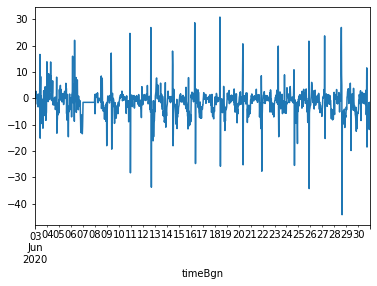

In [200]:
print(f'{ABBY.fluxCO2.isna().sum()} missing values before bfill.')

the_mean = ABBY.fluxCO2.mean()
ABBY.fluxCO2.fillna(value=the_mean, inplace=True)

print(f'{ABBY.fluxCO2.isna().sum()} missing values after  bfill.')


ABBY.fluxCO2.plot();


Now lets find the longest continous interval without NaNs.

In [ ]:
'''# extract values
a = TEAK.fluxCO2.values
# Make mask
m = np.concatenate(([True], np.isnan(a), [True]))  
# Make start-stop limits
ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)
# Get interval limits for slicing
start,stop = ss[(ss[:,1] - ss[:,0]).argmax()]
# TODO: after this step slice from start to stop out and repat to get all the longest intervals

# Get datetimes of interval
dates = list(TEAK.index)
print(start, stop - 1)
start, stop = dates[start], dates[stop - 1]
start, stop
''' 

In [203]:
dec = seasonal_decompose(ABBY.fluxCO2, model='additive', period=48)
d = dec.__dict__
d.keys()

dict_keys(['_seasonal', '_trend', '_weights', '_resid', '_observed'])

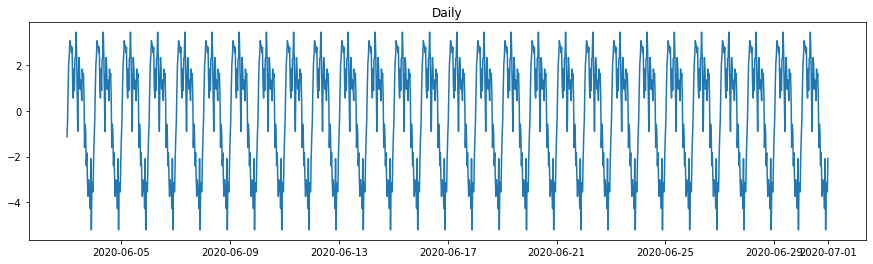

In [204]:
plt.figure(figsize=(15,4));
plt.plot(d['_seasonal']);
plt.title('Daily');

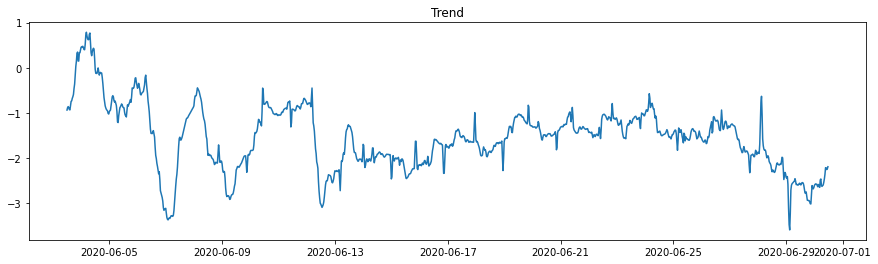

In [205]:
plt.figure(figsize=(15,4));
plt.plot(d['_trend']);
plt.title('Trend');

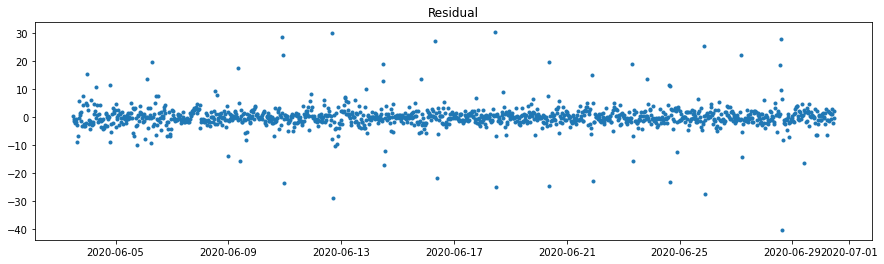

In [213]:
plt.figure(figsize=(15,4));
plt.plot(d['_resid'], linestyle='None', marker='.');
plt.title('Residual');

Make training and test datasets.

In [217]:
# make train dataset ; TODO: make this bigger once more data is downladed
cutoff_date = '2020-06-21'
_train = ABBY.fluxCO2[ABBY.index < cutoff_date]
_dates = _train.index

# make test data
test = ABBY.fluxCO2[ABBY.index >= cutoff_date]

# tf requires an an (N, 1) float tensor
train = _train.to_numpy().reshape(-1, 1)

Define Seasonal effects.

In [ ]:
# seasonal effect 1: daily cycle
weekly_cycle = tfp.sts.Seasonal(
    num_seasons=365, # days in year
    observed_time_series=train,
    allow_drift=True,
    name=’daily_effect’)

# seasonal effect 2: annual cycle

# trend ; TODO; define priors
trend = tfp.sts.SemiLocalLinearTrend(
    observed_time_series=train,
    name='trend')

# Residuals ; TODO; define priors
residuals = tfp.sts.Autoregressive(
    order=1,
    observed_time_series=train,
    coefficients_prior=None,
    level_scale_prior=None,
    initial_state_prior=None,
    name='residuals_autoregressive')

$$y =\sim \mathcal{N}(\mu, \sigma^{2}) \\
mu = \alpha + \beta_{0} \mathrm{clay} + \beta_{1} \mathrm{silt}$$
with priors
$$ \alpha \sim \mathcal{N}(0, 100) \\
\beta_{i} \sim \mathcal{N}(0, 100) \\
\sigma \sim |\mathcal{N}(0, 1)|$$

In [138]:
# Set seed.
tf.random.set_seed(42)
# Set tensor numeric type.
dtype = 'float32'

#convert to tensors
x = np.stack([df.clayTotal.values, df.siltTotal.values], axis=1)
x = tf.convert_to_tensor(x, dtype=dtype)

sand = tf.convert_to_tensor(df.sandTotal.values, dtype=dtype)
sand = tf.reshape(sand, (-1,1))

In [139]:
sand.shape

TensorShape([66, 1])

In [141]:
x.shape

TensorShape([66, 2])

Define model with Auto_Batched Joint Distribution.

In [142]:
jds_ab = tfd.JointDistributionNamedAutoBatched(dict(

    sigma=tfd.HalfNormal(scale=[tf.cast(1.0, dtype)]),

    alpha=tfd.Normal(
        loc=[tf.cast(0.0, dtype)], 
        scale=[tf.cast(10.0, dtype)]
    ),

    beta=tfd.Normal(
        loc=[[tf.cast(0.0, dtype)], [tf.cast(0.0, dtype)]], 
        scale=[[tf.cast(2.3, dtype)], [tf.cast(2.3, dtype)]]
    ),

    y=lambda beta, alpha, sigma: 
        tfd.Normal(
            loc=tf.linalg.matmul(x, beta) + alpha, 
            scale=sigma
        ) 
))

Generate som eprior predictions

In [143]:
# Sample from the prior.
prior_samples = jds_ab.sample(500)['y']

In [144]:
prior_samples = tf.squeeze(prior_samples)
prior_mean = tf.math.reduce_mean(prior_samples, axis=0).numpy()
prior_std = tf.math.reduce_std(prior_samples, axis=0).numpy()

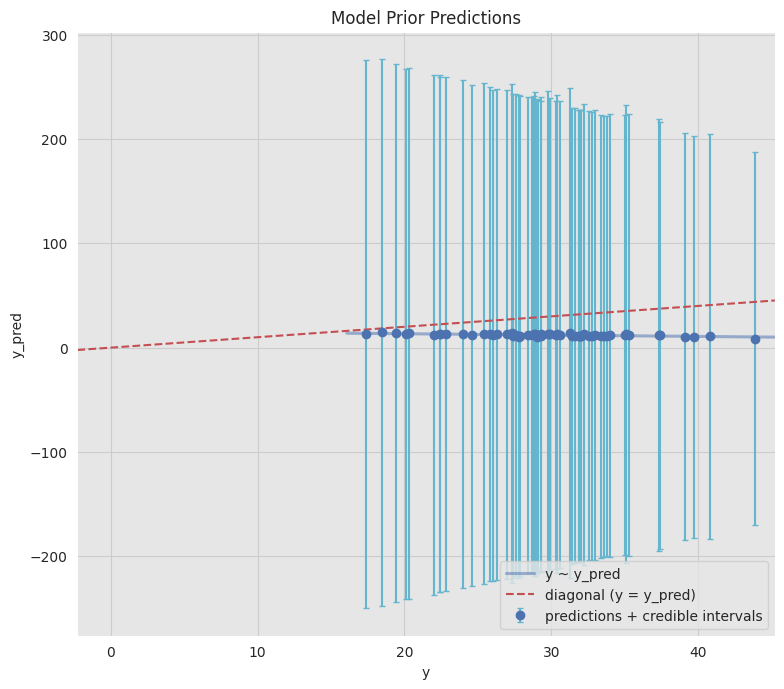

In [145]:
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

fig, ax = plt.subplots(figsize=(9, 8)) 
ax.errorbar(
    x=tf.squeeze(y).numpy(), 
    y=prior_mean, 
    yerr=2*prior_std,
    fmt='o',
    ecolor=sns_c[9],
    capsize=2,
    label='predictions + credible intervals',
)
sns.regplot(
    x=tf.squeeze(y).numpy(), 
    y=prior_mean, 
    color=sns_c[0], 
    scatter=False,
    line_kws=dict(alpha=0.5), 
    label='y ~ y_pred', 
    truncate=False,
    ax=ax
)
ax.axline(xy1=(0,0), slope=1, linestyle='--', color=sns_c[3], label='diagonal (y = y_pred)')
ax.legend(loc='lower right')
ax.set(title='Model Prior Predictions', xlabel='y', ylabel='y_pred');

In [131]:
beta, alpha, sigma = None, None, None

def target_log_prob_fn(beta=beta, alpha=alpha, sigma=sigma):
    return jds_ab.log_prob(beta=beta, alpha=alpha, sigma=sigma, y=sand)

In [132]:
# Size of each chain.
num_results = int(1e4)
# Burn-in steps.
num_burnin_steps = int(1e3)
# Hamiltonian Monte Carlo transition kernel. 
# In TFP a TransitionKernel returns a new state given some old state.
hcm_kernel  = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=target_log_prob_fn,
  step_size=1.0,
  num_leapfrog_steps=3)

# This adapts the inner kernel's step_size.
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
  inner_kernel = hcm_kernel,
  num_adaptation_steps=int(num_burnin_steps * 0.8))

In [133]:
@tf.function
def run_chain():
  '''Runs the chain, with burn-in. 
  Implements MCMC via repeated TransitionKernel steps.'''
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          tf.convert_to_tensor([[1.0], [1.0]], dtype=dtype),
          tf.convert_to_tensor([1.0], dtype=dtype), 
          tf.convert_to_tensor([1.0], dtype=dtype)
      ],
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted
    )
  return samples

In [134]:
# Set number of chains. 
num_chains = 5
# Run sampling. 
chains = [run_chain() for i in range(num_chains)]

In [135]:
chains_t = list(map(list, zip(*chains)))
chains_samples = [tf.squeeze(tf.concat(samples, axis=0)) for samples in chains_t]


chains_df = pd.concat(
    objs=[pd.DataFrame(samples.numpy()) for samples in chains_samples], 
    axis=1)

params = ['beta_0', 'beta_1', 'alpha', 'sigma']
chains_df.columns = params

chains_df = chains_df.assign(
    sample_id=lambda x: range(x.shape[0]), 
    chain_sample_id=lambda x: x['sample_id'] % num_results,
    chain_id=lambda x: (x['sample_id'] / num_results).astype(int) + 1).assign(
    chain_id=lambda x: 'c_' + x['chain_id'].astype(str))
    
chains_df.head()

,beta_0,beta_1,alpha,sigma,sample_id,chain_sample_id,chain_id
0,1.0,1.0,1.0,1.0,0,0,c_1
1,1.0,1.0,1.0,1.0,1,1,c_1
2,1.0,1.0,1.0,1.0,2,2,c_1
3,1.0,1.0,1.0,1.0,3,3,c_1
4,1.0,1.0,1.0,1.0,4,4,c_1


In [115]:
chains_df.beta_0.max()

1.0

LinAlgError: singular matrix

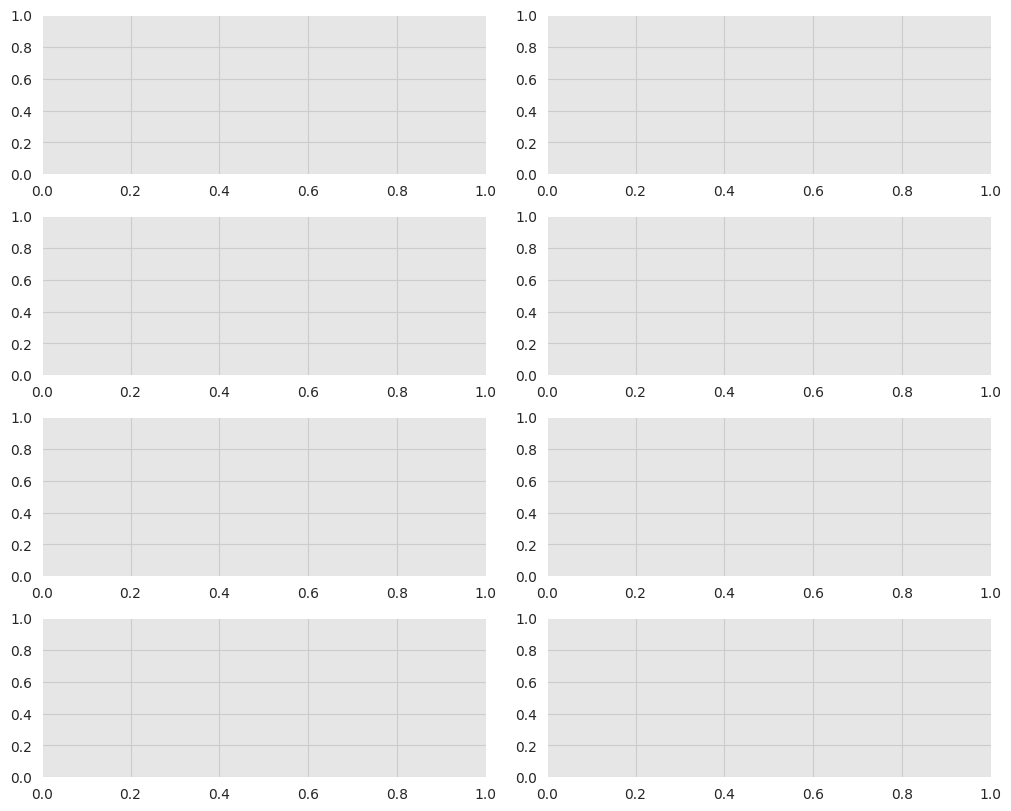

In [114]:
fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(10, 8), constrained_layout=True)

for i, param in enumerate(params):
    sns.histplot(x=param, data=chains_df, hue='chain_id', kde=True, ax=axes[i][0])
    sns.lineplot(x='chain_sample_id', y=param, data=chains_df, hue='chain_id', alpha=0.3, legend=False, ax=axes[i][1])

fig.suptitle('Posterior Samples per Chain', y=1.03);

In [163]:
# Set seed.
tf.random.set_seed(42)
# Set tensor numeric type.
dtype = 'float32'

#convert to tensors
x = np.stack([df.clayTotal.values, df.siltTotal.values], axis=1)
x = tf.convert_to_tensor(x, dtype=dtype)

y = tf.convert_to_tensor(df.sandTotal.values, dtype=dtype)
y = tf.reshape(sand, (-1,1))

print(x.shape , y.shape)

(66, 2) (66, 1)


In [164]:
jds_ab = tfd.JointDistributionNamedAutoBatched(dict(

    sigma=tfd.HalfNormal(scale=[tf.cast(1.0, dtype)]),

    alpha=tfd.Normal(
        loc=[tf.cast(0.0, dtype)], 
        scale=[tf.cast(10.0, dtype)]
    ),

    beta=tfd.Normal(
        loc=[[tf.cast(0.0, dtype)], [tf.cast(0.0, dtype)]], 
        scale=[[tf.cast(10.0, dtype)], [tf.cast(10.0, dtype)]]
    ),

    y=lambda beta, alpha, sigma: 
        tfd.Normal(
            loc=tf.linalg.matmul(x, beta) + alpha, 
            scale=sigma
        ) 
))

In [165]:
# Sample from the prior.
prior_samples = jds_ab.sample(500)['y']



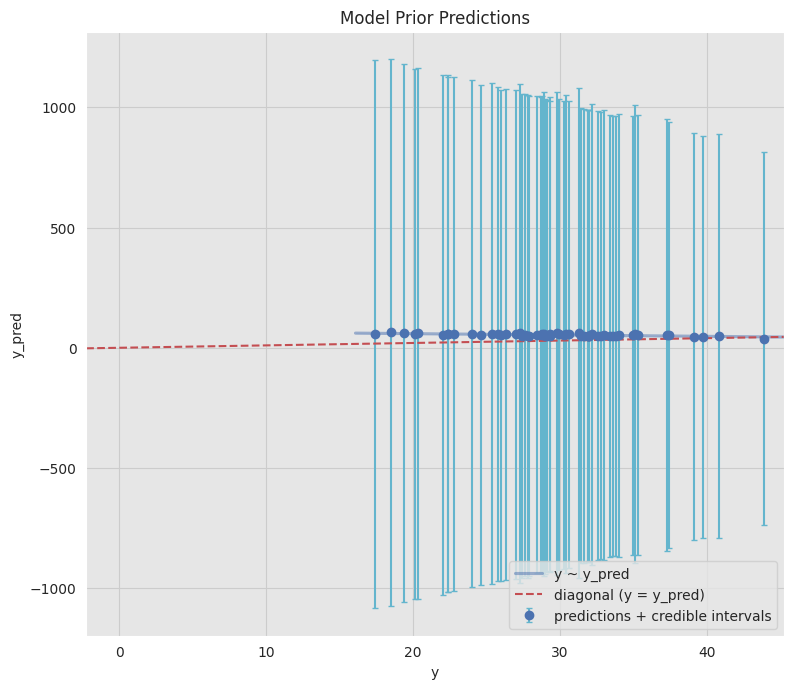

In [167]:
prior_samples = tf.squeeze(prior_samples)
prior_mean = tf.math.reduce_mean(prior_samples, axis=0).numpy()
prior_std = tf.math.reduce_std(prior_samples, axis=0).numpy()

fig, ax = plt.subplots(figsize=(9, 8)) 
ax.errorbar(
    x=tf.squeeze(y).numpy(), 
    y=prior_mean, 
    yerr=2*prior_std,
    fmt='o',
    ecolor=sns_c[9],
    capsize=2,
    label='predictions + credible intervals',
)
sns.regplot(
    x=tf.squeeze(y).numpy(), 
    y=prior_mean, 
    color=sns_c[0], 
    scatter=False,
    line_kws=dict(alpha=0.5), 
    label='y ~ y_pred', 
    truncate=False,
    ax=ax
)
ax.axline(xy1=(0,0), slope=1, linestyle='--', color=sns_c[3], label='diagonal (y = y_pred)')
ax.legend(loc='lower right')
ax.set(title='Model Prior Predictions', xlabel='y', ylabel='y_pred');

In [168]:
def target_log_prob_fn(beta=beta, alpha=alpha, sigma=sigma):
    return jds_ab.log_prob(beta=beta, alpha=alpha, sigma=sigma, y=y)

In [169]:
# Size of each chain.
num_results = int(1e4)
# Burn-in steps.
num_burnin_steps = int(1e3)
# Hamiltonian Monte Carlo transition kernel. 
# In TFP a TransitionKernel returns a new state given some old state.
hcm_kernel  = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=target_log_prob_fn,
  step_size=1.0,
  num_leapfrog_steps=3
  
)
# This adapts the inner kernel's step_size.
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
  inner_kernel = hcm_kernel,
  num_adaptation_steps=int(num_burnin_steps * 0.8)
)
# Run the chain (with burn-in).
@tf.function
def run_chain():
  # Run the chain (with burn-in). 
  # Implements MCMC via repeated TransitionKernel steps.
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          tf.convert_to_tensor([[1.0], [1.0]], dtype=dtype),
          tf.convert_to_tensor([1.0], dtype=dtype), 
          tf.convert_to_tensor([1.0], dtype=dtype)
      ],
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted
    )
  return samples

In [170]:
# Set number of chains. 
num_chains = 2
# Run sampling. 
chains = [run_chain() for i in range(num_chains)]

In [171]:
chains_t = list(map(list, zip(*chains)))

chains_samples = [tf.squeeze(tf.concat(samples, axis=0)) for samples in chains_t]

chains_df = pd.concat(
    objs=[pd.DataFrame(samples.numpy()) for samples in chains_samples], 
    axis=1
)

params = ['beta_0', 'beta_1', 'alpha', 'sigma']
chains_df.columns = params

chains_df = chains_df \
    .assign(
        sample_id=lambda x: range(x.shape[0]), 
        chain_sample_id=lambda x: x['sample_id'] % num_results,
        chain_id=lambda x: (x['sample_id'] / num_results).astype(int) + 1
    ) \
    .assign(chain_id=lambda x: 'c_' + x['chain_id'].astype(str)) \
    

chains_df.head()

,beta_0,beta_1,alpha,sigma,sample_id,chain_sample_id,chain_id
0,1.0,1.0,1.0,1.0,0,0,c_1
1,1.0,1.0,1.0,1.0,1,1,c_1
2,1.0,1.0,1.0,1.0,2,2,c_1
3,1.0,1.0,1.0,1.0,3,3,c_1
4,1.0,1.0,1.0,1.0,4,4,c_1


In [ ]:
col = 'soilTempMean_z509h001'
val = col.split('_')[0]
# find all of the colums corresponding to the value of interest at other sensors
feature_names = [c for c in SITE.columns if col not in c and val in c]
feature_names.sort()
cols = [col] + feature_names

SITE['timeBgn'] = SITE.timeBgn.astype('datetime64')
da = SITE[cols].to_dask_array()
idx = SITE['timeBgn'].to_dask_array()
# make a dask df
ddf = dd.from_array(da, columns=cols)
idx  = dd.from_array(idx)
ddf = ddf.merge(idx.to_frame(name='timeBgn'))
# get the 20 feature columns with the fewest NaNs
feature_names = [c for c in ddf.columns if col not in c and val in c]
best_cols = list(ddf[feature_names].isnull().sum().nsmallest(21).index)

cor = ddf[[col] + best_cols].corr().compute()
best_cols = list(cor[col].sort_values().head(3).index)

best_cols

In [ ]:
# depricated attmept at imputation

def bnn_impute(df, col, verbose=1):
    # seperate the name of value of interest from the sensor name
    val = col.split('_')[0]
    expun = val + 'ExpUncert'
    uncert = [c for c in SITE.columns if 'soilTempExpUncert' in c]
    uncert = SITE[uncert].values.astype(np.float32).flatten()
    noise_std = np.float32(uncert[np.logical_not(np.isnan(uncert))].mean() / 2)
    
    # find all of the colums corresponding to the value of interest at other sensors
    feature_names = [c for c in df.columns if col not in c and val in c]
    feature_names.sort()
    cols = [col] + feature_names
    
    # make timeBgn into datetime
    df['timeBgn'] = df.timeBgn.astype('datetime64')
    # create dask array of values from the df
    da = df[cols].to_dask_array()
    idx = df['timeBgn'].to_dask_array()
    # make a dask df
    if verbose: print('Making dask dataframe.')
    ddf = dd.from_array(da, columns=cols)
    idx  = dd.from_array(idx)
    ddf = ddf.merge(idx.to_frame(name='timeBgn'))
    # get the 20 feature columns with the fewest NaNs
    if verbose: print('selecting columns.')
    best_cols = list(ddf[feature_names].isnull().sum().nsmallest(21).index)
    # now reduce that to the three  (of the 20) wich correlate most with col
    cor = ddf[[col] + best_cols].corr().compute()
    best_cols = list(cor[col].sort_values().head(3).index)
    
    
    xxx = ddf[['timeBgn', col] + best_cols]
    xxx.set_index('timeBgn')
    xxx = xxx.compute()
    
    xxx[[col] + best_cols].plot(subplots=True, figsize=(12, 12))
    xxx[[col] + best_cols][:480].plot(subplots=True, figsize=(12, 12))
    
    date_time = pd.to_datetime(xxx.pop('timeBgn'))
    
    d = xxx[col].values.astype(np.float32)
    
    trend = tfp.sts.LocalLinearTrend(observed_time_series=d)
       
    
    
   
    
    
    return(1,2,3,4)
   
    
    # get the data that has non NaN values for the target (col)
    if verbose: print('Dividing datframes and filling NaNs.')
    data = ddf[~ddf[col].isna()]
    # subset to 3 best columns
    data = data[[col, 'timeBgn'] + best_cols]
    # fil NaNs using mean
    data[best_cols] = data[best_cols].fillna(data[best_cols].mean())
    
    # get the data for which predictions need to be made
    nans = ddf[ddf[col].isna()]
    # subset to 3 best columns
    nans = nans[['timeBgn'] + best_cols]
    # fil NaNs using mean
    nans[best_cols] = nans[best_cols].fillna(nans[best_cols].mean())
    
    # scale and center the features
    if verbose: print('Scaling and centering.')
    scaler = StandardScaler()
    data_ = scaler.fit_transform(data[best_cols])
    nans_ = scaler.transform(nans[best_cols])
    
    # remove outliers, data
    if verbose: print('Removing outliers (train/val data).')
    is_inlier = IsolationForest(random_state=0).fit_predict(data_)
    data_ = data_[is_inlier > 0, :]
    new_labels = data.timeBgn.values[is_inlier > 0]
    new_col = data[col].values[is_inlier > 0]
    
    # make back into df, data
    if verbose: print('Returning data to datframes.')
    data_ = pd.DataFrame(data_, columns=best_cols) 
    data_['timeBgn'] = new_labels
    data_[col] = new_col
    
    # remove outliers, nans
    #if verbose: print('Removing outliers (features for imputation).')
    #is_inlier = IsolationForest(random_state=0).fit_predict(nans_)
    #nans_ = nans_[is_inlier > 0, :]
    #new_labels = nans.timeBgn.values[is_inlier > 0]
    
    # make back into df, nans
    nans_ = pd.DataFrame(nans_, columns=best_cols) 
    nans_['timeBgn'] = nans.timeBgn.values
    
    # hyper params
    n_epochs = 30
    n_samples = data_.shape[0]
    n_batches = 10
    batch_size = np.floor(n_samples / n_batches)
    buffer_size = n_samples
    
    # make tf dataset
    if verbose: print('Creating and splitting dset.')
    dset = tf.data.Dataset.from_tensor_slices((data_[best_cols].values.astype(np.float32),
                                               data_[col].values.astype(np.float32)))
    dset = dset.shuffle(n_samples, reshuffle_each_iteration=True)
    
    #train test split
    n_train = int(0.7 * data.shape[0].compute())
    train = dset.take(n_train).batch(batch_size).repeat(n_epochs)
    test = dset.skip(n_train).batch(1)
    
    # define prior
    loc = data[col].values.astype(np.float32).mean().compute()
    scale = data[best_cols].values.astype(np.float32).std().compute() + noise_std
    prior = tfd.Normal(loc=loc, scale=scale)
    
    # make model
    model = tfk.Sequential([
        tfk.layers.GaussianNoise(noise_std, input_shape=(len(best_cols), ), name='input'),
        tfp.layers.DenseFlipout(2*len(best_cols), activation='relu', name='dense_1'),
        tfp.layers.DenseFlipout(
            tfp.layers.IndependentNormal.params_size(1),
            activation=None,
            name='distribution_weights'),
        tfp.layers.IndependentNormal(1,
                                     activity_regularizer=tfp.layers.KLDivergenceRegularizer(
                                         prior,
                                         weight=1/n_batches), name="output")
    ], name='sensor_impute_model')
    
    
    # compile model
    if verbose: print('Compiling model.')
    neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
    model.compile(optimizer="adam", loss=neg_log_likelihood)
    
    # train
    if verbose: print('Fitting model.')
    model.fit(train, epochs=n_epochs, validation_data=test, verbose=verbose)
    
    
    # make perdictions
    if verbose: print('Making predictions for validation.')
    samples = 500
    iterations = 10

    test_iterator = tf.compat.v1.data.make_one_shot_iterator(test)

    X_true = np.empty(shape=(samples, len(best_cols)))
    Y_true = np.empty(shape=(samples, len(col)))
    Y_pred = np.empty(shape=(samples, len(col), iterations))

    for i in range(samples):
        features, labels = test_iterator.get_next()
        X_true[i,:] = features
        Y_true[i,:] = labels.numpy()
        for k in range(iterations):
            Y_pred[i,:,k] = model.predict(features)

    Y_pred_m = np.mean(Y_pred, axis=-1)
    Y_pred_s = np.std(Y_pred, axis=-1)

    r2 = r2_score(Y_true, Y_pred_m)
    mse = mean_squared_error(Y_true, Y_pred_m)
    ev = explained_variance_score(Y_true, Y_pred_m)

    if verbose:
        print(f'r2: {r2}\nmse: {mse}\nev: {ev}')

        plt.scatter(Y_pred_m, Y_true);
        plt.xlabel('y_pred');
        plt.ylabel('y_true');

        plt.xlim(5, 15);
        plt.ylim(5, 15);
        plt.show()
    
    
    return(model, Y_pred_m, Y_pred_s, Y_true)



col = 'soilTempMean_z509h001'

t = time.time()
model, Y_pred_m, Y_pred_s, Y_true = bnn_impute(SITE, col)
t = (time.time() - t) / 60
print(f'Christ! that took {t} minutes!')


In [ ]:
 # attmept to sperate regions of bad data
    # too slow, runs forever

def bad_chunk_search(df, col, contig=50):
    '''searches a int encoded boolean column for regions where 1s are not
    seperated by a contigous stretch of zeros of length contig.
    labels those regions as ...'''
    bad_chunks = []
    n = len(df)
    start = 0
    column = df[col]
    first_try = True
    end_slice = start + contig
    while end_slice < n + 1:
        # if there is dirt closer than contig to start: 
        if column.values[start:end_slice].sum() > 0:
            # make the search window of length 1
            end_slice = start + 1
            # and expand it until it finds the index of the dirt
            while column.values[start:end_slice].sum() == 0:
                schmutzanfang = end_slice
                schmutzhaufen = 1 
                end_slice = end_slice + 1
            # set start as where the dirt was found and end_slice contig further
            start = schmutzanfang
            end_slice = start + contig
            # then while there is dirt within contig of start:
            while column.values[start:end_slice].sum() > schmutzhaufen: 
                start = start + 1
                schmutzende = start
                end_slice = start + contig
            
            # make a tuple of slice indeices to find the chunk later
            chunk = (schmutzanfang, schmutzende) 
            bad_chunks.append(chunk)
    return(bad_chunks)


#
bc = bad_chunk_search(bddf, col, contig=50)

# Gas diffusivity constant (effective diffusivity) #

\begin{equation} \label{BCM96}
    \frac{D_{s, 100}}{D_{0}} = (2 \; \epsilon_{100}^{3} + 0.04) \; \left( \frac{\epsilon}{\epsilon_{100}} \right)^{2+3/b}
\end{equation}
where $b$ is the soil water retention parameter determined by Cambell \cite{campbell1974}, which is calculated by finding the slope of $\log{\epsilon}$ vs.  $\log{-\Psi}$.  

Normally, In order to calculate $D_{s}$,  SWC must be known for at least two values of $\Psi$ (one of which is needing to be $\Psi_{100}$), though more are desirable for determining $b$.  In our bayesian model we will be drawing particle size fractions from a distribution and using those values to calculate the relationship between $\Psi$ based on  $\epsilon$  using the method described above.  There will thus be a distribution of values for $\Psi$, and a a resulting deterministic (unless I add noise later) distribution of values for $\epsilon$. The log-log regressing to find b can be performed to find a posterior for b. 

In order to calculate $D_{s}$ then we must first calculate the matric potential. To do this we must find the sand and clay fractions of the soil.

### soil particle dsitribution ###
The soil pits are often very lose to the base of the tower, rather than scattered about the tower footprint.  Furthermore, since soil composition veries so much over space it hardly seems reasonable to try to estimate the actual values for sand and clay at each sensor location.  Instead we will just define a joint probablitity distribution of sand, caly and silt percentages based on the observed data.  We can draw from it later as a model parameter.# Bib

@article{moldrup2000predicting,
  title={Predicting the gas diffusion coefficient in undisturbed soil from soil water characteristics},
  author={Moldrup, P and Olesen, Torben and Schj{\o}nning, Per and Yamaguchi, T and Rolston, DE},
  journal={Soil Science Society of America Journal},
  volume={64},
  number={1},
  pages={94--100},
  year={2000},
  publisher={Wiley Online Library}
}